# Проект: промышленность 

**Описание проекта:**     
чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.     

**Цель:**    
построить модель, которая будет предсказывать температуру сплава.

Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.    

**Описание этапа обработки:**    
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.    

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).    

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание данных:**  

Данные состоят из нескольких файлов, полученных из разных источников:     
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

**Состав данных:** 
- **data_arc_new**:
    - **key** — номер партии;    
    - **Начало нагрева дугой** — время начала нагрева;
    - **Конец нагрева дугой** — время окончания нагрева;
    - **Активная мощность** — значение активной мощности;
    - **Реактивная мощность** — значение реактивной мощности.
- **data_bulk_new**:   
    - **key** — номер партии;
    - **Bulk 1 … Bulk 15** — объём подаваемого материала.
- **data_bulk_time_new**:   
    - **key** — номер партии;
    - **Bulk 1 … Bulk 15** — время подачи материала.
- **data_gas_new**:  
    - **key** — номер партии;
    - **Газ 1** — объём подаваемого газа.
- **data_temp_new**:
    - **key** — номер партии;
    - **Время замера** — время замера;
    - **Температура** — значение температуры.
- **data_wire_new**:
    - **key** — номер партии;
    - **Wire 1 … Wire 9** — объём подаваемых проволочных материалов.
- **data_wire_time_new**:
    - **key** — номер партии;
    - **Wire 1 … Wire 9** — время подачи проволочных материалов.

## Загрузка данных

In [1]:
%%time
from datetime import datetime as dt, timedelta
start_time = dt.now()

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 16 µs


In [2]:
!pip install phik -q

In [3]:
import pandas as pd
import seaborn as sns
import numpy  as np
import phik
from scipy import stats

from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline

from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge
)
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder
)
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    confusion_matrix
)

# зададим параметры окна вывода графиков
plt.rcParams["figure.figsize"] = (10,7)

### Загружаем данные об электродах

In [4]:
df_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv',
                           sep=',',
                           decimal='.',
                           parse_dates=['Начало нагрева дугой','Конец нагрева дугой'])
display(df_arc_new.head())
display(df_arc_new.info())
display(df_arc_new['key'].duplicated().sum())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

11662

В наборе 14876 записей, тип данных соответствующий. Пустых значений нет. В поле key находятся дублирующиеся значения (11662 записи), потому что описана серия измерений внутри партии.

### Загружаем данные об объемах подачи сыпучих материалов

In [5]:
df_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv',
                           sep=',',
                           decimal='.')
display(df_bulk_new.head())
display(df_bulk_new.info())
display(df_bulk_new['key'].duplicated().sum())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

0

В наборе 3129 записей, тип данных соответствующий. Пустые значения есть в нескольких полях, изучим их позже. В поле key отсутствуют дублирующиеся значения, так что 1-й партии соответствует 1-а запись.

### Загружаем данные о времени подачи сыпучих материалов

In [6]:
df_bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv',
                           sep=',',
                           decimal='.',
                           parse_dates=['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5','Bulk 6','Bulk 7','Bulk 8',
                                       'Bulk 9','Bulk 10','Bulk 11','Bulk 12','Bulk 13','Bulk 14','Bulk 15'])
display(df_bulk_time_new.head())
display(df_bulk_time_new.info())
display(df_bulk_time_new['key'].duplicated().sum())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

0

В наборе 3129 записей, тип данных соответствующий. Пустые значения есть в нескольких полях, изучим их позже. В поле key отсутствуют дублирующиеся значения, так что 1-й партии соответствует 1-а запись.

### Загружаем данные о продувке сплава газом

In [7]:
df_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv',
                           sep=',',
                           decimal='.')
display(df_gas_new.head())
display(df_gas_new.info())
display(df_gas_new['key'].duplicated().sum())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

0

В наборе 3239 записей, тип данных соответствующий. Пустые значения отсутствуют. В поле key отсутствуют дублирующиеся значения, так что 1-й партии соответствует 1-а запись.

### Загружаем данные с результатами измерения температуры

In [8]:
df_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv',
                           sep=',',
                           decimal='.',
                           parse_dates=['Время замера'])
display(df_temp_new.head())
display(df_temp_new.info())
display(df_temp_new['key'].duplicated().sum())

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

14876

В наборе 18029 записей, тип данных соответствующий. Пустые значения есть в поле Температура, изучим их позже. В поле key присутствуют дублирующиеся значения (14876 записей), потому что описана серия измерений в одной партии.

### Загружаем данные об объемах подачи проволчных материалов

In [9]:
df_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv',
                           sep=',',
                           decimal='.')
display(df_wire_new.head())
display(df_wire_new.info())
display(df_wire_new['key'].duplicated().sum())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

0

В наборе 3081 запись, тип данных соответствующий. Пустые значения есть в нескольких полях, изучим их позже. В поле key отсутствуют дублирующиеся значения, так что 1-й партии соответствует 1-а запись.

### Загружаем данные о времени подачи проволочных материалов

In [10]:
df_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv',
                           sep=',',
                           decimal='.',
                           parse_dates=['Wire 1','Wire 2','Wire 3','Wire 4','Wire 5','Wire 6',
                                        'Wire 7','Wire 8','Wire 9'] )
display(df_wire_time_new.head())
display(df_wire_time_new.info())
display(df_wire_time_new['key'].duplicated().sum())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

0

В наборе 3081 запись, тип данных соответствующий. Пустые значения есть в нескольких полях, изучим их позже. В поле key отсутствуют дублирующиеся значения, так что 1-й партии соответствует 1-а запись.

**Вывод по результатам загрузки данных**    
Данные успешно загружены и преобразованы к соответствующим типам во время загрузки.     
- в данных есть пустые значения, которые мы исследуем на этапе исследовательского анализа;
- в данных есть дублирующиеся значения в поле key, которые не являются аномалией, покольку описывается серия измерений, относящихся к одной партии;
- количество записей в наборах, где нет повторяющихся записей, разное, так что в выходном наборе общее количество записей будет еще меньше, чем 3081.

## Исследовательский анализ и предобработка данных

### Временные интервалы нагрева электродов и показатели мощности - df_arc_new

In [11]:
display(df_arc_new.head())
display(df_arc_new.describe())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Статистика показывает, что поле *Реактивная мощность* содержит значение -715.479924. Проверим, сколько отрицательных значений в этой колонке.

In [12]:
display(df_arc_new[df_arc_new['Реактивная мощность']<=0]['Реактивная мощность'].count())

1

Отрицательное значение оказалось одно, поэтому будем считать, что это аномальное значение, и мы его удалим. Предварительно сохраним значение ключа, соответствующее этой записи в значение константы, чтобы удалить записи, который будут привязаны к этому ключу в других датафреймах.

In [13]:
KEY_ARC_NEW = df_arc_new[df_arc_new['Реактивная мощность']<=0]['key']
df_arc_new = df_arc_new[df_arc_new['Реактивная мощность']>0]

Выводим на экран датафрейм и статистику, чтобы убедиться в корректности операций.

In [14]:
display(df_arc_new.head())
display(df_arc_new.describe())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115
std,934.593897,0.258894,0.197612
min,1.000000,0.223120,0.153777
25%,806.000000,0.467115,0.337190
50%,1617.000000,0.599578,0.441665
75%,2429.000000,0.830135,0.608223
max,3241.000000,1.463773,1.270284


Подсчитаем количество пустых значений, дублей и уникальных значений поля key в датафрейме.

In [15]:
display(df_arc_new.isna().sum())
display(f'Дублей: {df_arc_new.duplicated().sum()}')
display(len(df_arc_new['key'].unique().tolist()))

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

'Дублей: 0'

3214

Пустых значений нет, дублей нет, уникальных значений 3214. Данные выглядят адекватно, поэтому переходим к построению графиков.

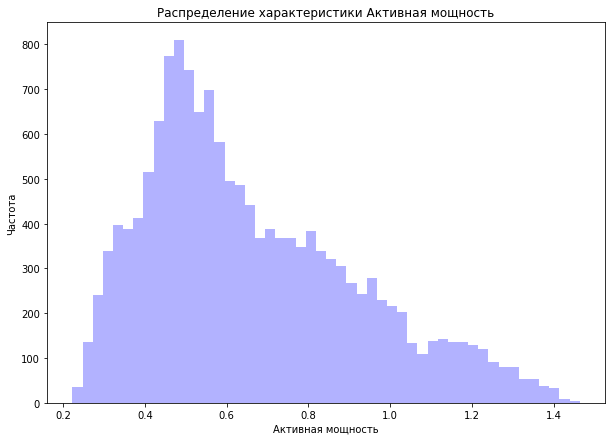

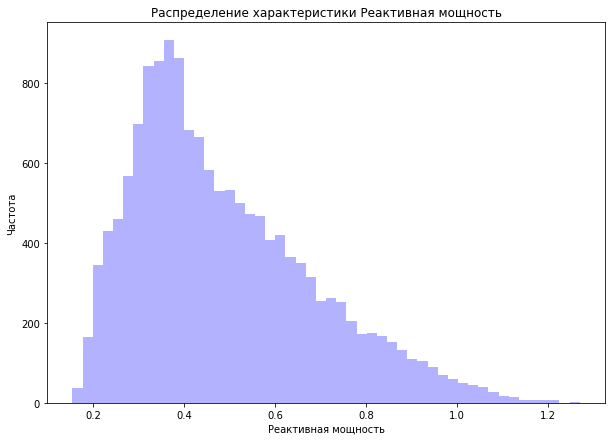

In [16]:
# посмотрим на распределение численных непрерывных характеристик
for i in df_arc_new.select_dtypes('float64'):
    ax = df_arc_new[i].plot(kind='hist', bins=50, color = 'blue', alpha = 0.3)
    ax.set_title(f'Распределение характеристики {i}')
    ax.set_xlabel(f'{i}')
    ax.set_ylabel('Частота')
    plt.show()

Распределения величин близки к нормальному, но имеют ярко выраженное смещение влево. При этом распределение Реактивной мощности более равномерное, а распределение Активной мощности имеет выбросы и провалы.

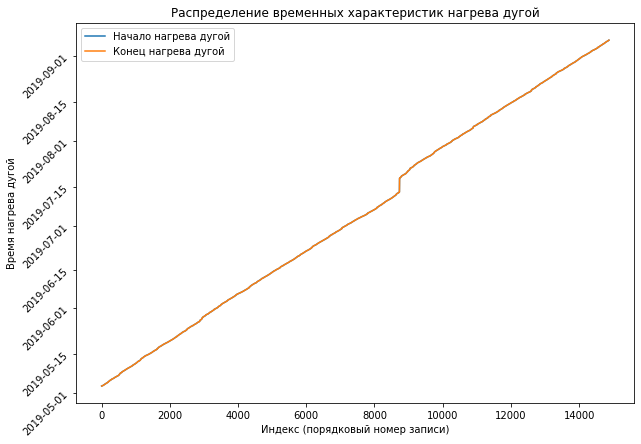

In [17]:
# распределение характеристик времени
ax = df_arc_new[['Начало нагрева дугой','Конец нагрева дугой']].plot()
ax.set_title('Распределение временных характеристик нагрева дугой')
ax.set_ylabel('Время нагрева дугой')    
ax.set_xlabel('Индекс (порядковый номер записи)')
plt.yticks(rotation=45)
plt.show()

Графики повторяют друг друга и имеют одинаковый странный всплеск в районе индекса 9000 и даты 2019-07-01. Поскольку по оси Y у нас отложены даты, то этот всплеск относится к пока для нас необъяснимому временному разрыву в записях.      
Увеличим этот фрагмент, чтобы рассмотреть внимательнее график.

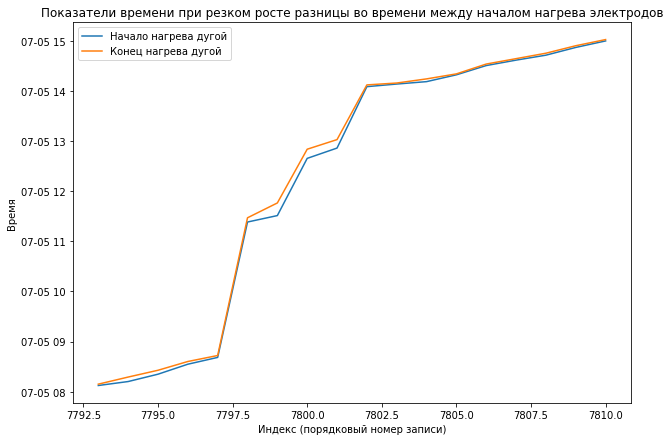

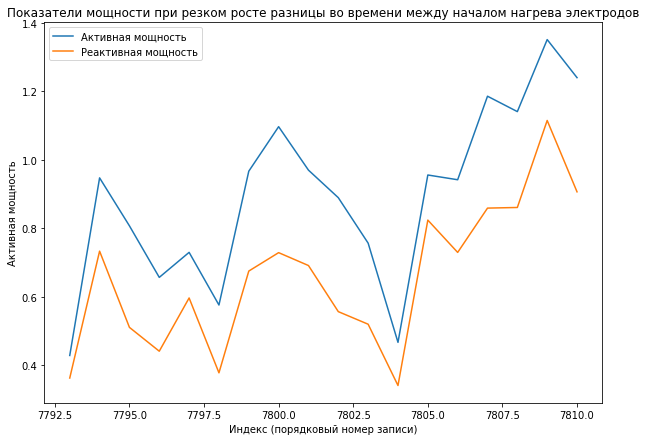

In [18]:
ax = df_arc_new[(df_arc_new['Начало нагрева дугой']>='2019-07-05 08:00:00')&
           (df_arc_new['Начало нагрева дугой']<='2019-07-05 15:00:00')][['Начало нагрева дугой','Конец нагрева дугой']].plot()
ax.set_title('Показатели времени при резком росте разницы во времени между началом нагрева электродов')
ax.set_xlabel('Индекс (порядковый номер записи)')
ax.set_ylabel('Время')
plt.show()
ax = df_arc_new[(df_arc_new['Начало нагрева дугой']>='2019-07-05 08:00:00')&
           (df_arc_new['Начало нагрева дугой']<='2019-07-05 15:00:00')][['Активная мощность','Реактивная мощность']].plot()
ax.set_title('Показатели мощности при резком росте разницы во времени между началом нагрева электродов')
ax.set_xlabel('Индекс (порядковый номер записи)')
ax.set_ylabel('Активная мощность')
plt.show()

In [19]:
list = df_arc_new[(df_arc_new['Начало нагрева дугой']>='2019-07-05 08:00:00')&
           (df_arc_new['Начало нагрева дугой']<='2019-07-05 15:00:00')]['key'].unique().tolist()
display(list, len(list))
df_arc_new[(df_arc_new['key']==list[0])|(df_arc_new['key']==list[1])]

[1689, 1690]

2

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
7793,1689,2019-07-05 08:07:21,2019-07-05 08:08:58,0.428776,0.362902
7794,1689,2019-07-05 08:12:06,2019-07-05 08:17:28,0.947266,0.733328
7795,1689,2019-07-05 08:20:53,2019-07-05 08:25:36,0.807232,0.510813
7796,1689,2019-07-05 08:32:51,2019-07-05 08:36:06,0.656772,0.441245
7797,1689,2019-07-05 08:41:00,2019-07-05 08:43:17,0.729808,0.596656
7798,1689,2019-07-05 11:23:07,2019-07-05 11:28:12,0.576072,0.378107
7799,1689,2019-07-05 11:30:50,2019-07-05 11:45:57,0.966775,0.675200
7800,1689,2019-07-05 12:39:20,2019-07-05 12:50:18,1.096739,0.728982
7801,1689,2019-07-05 12:51:41,2019-07-05 13:01:49,0.969873,0.691339
7802,1689,2019-07-05 14:05:14,2019-07-05 14:07:19,0.889432,0.556732


Методом укрупнения получился интервал 2019-07-05 08:00:00 - 2019-07-05 15:00:00, который относится к ключу 1689, когда произошло резкое увеличение интервала между последовательными записями о нагреве электродов. Возьмем на заметку, если где-то в других наборах "всплывет" похожая аномалия.

**Вывод по данным о временных интервалах нагрева электродов**

Данные о временных интервалах нагрева электродов выглядят нормально, записи о времени последовательные, явные петли отсутствуют, уникальных значений в поле key - 3214.  Обнаружено резкое увеличение размера временного интервала между последовательными записями, относящимися к партии 1689.     
Возьмем на заметку, если что-то похожее проявится для этой партии в других наборах.

### Объемы подачи сыпучих материалов - df_bulk_new

In [20]:
display(df_bulk_new.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


В данных много пустых значений. Проверим, что в датафрейме отсутствуют нулевые значения и если это так, то после исследования данных заполним все пропуски нулями.

In [21]:
for i in df_bulk_new:
    display(f'В колонке {i} {round(df_bulk_new[df_bulk_new[i]==0][i].sum())} нулевых значений')

'В колонке key 0 нулевых значений'

'В колонке Bulk 1 0 нулевых значений'

'В колонке Bulk 2 0 нулевых значений'

'В колонке Bulk 3 0 нулевых значений'

'В колонке Bulk 4 0 нулевых значений'

'В колонке Bulk 5 0 нулевых значений'

'В колонке Bulk 6 0 нулевых значений'

'В колонке Bulk 7 0 нулевых значений'

'В колонке Bulk 8 0 нулевых значений'

'В колонке Bulk 9 0 нулевых значений'

'В колонке Bulk 10 0 нулевых значений'

'В колонке Bulk 11 0 нулевых значений'

'В колонке Bulk 12 0 нулевых значений'

'В колонке Bulk 13 0 нулевых значений'

'В колонке Bulk 14 0 нулевых значений'

'В колонке Bulk 15 0 нулевых значений'

Нулевые значения отсутствуют, так что подсчитаем количество пропусков, дубликатов и уникальных записей в поле key.

In [22]:
display(df_bulk_new.isna().sum())
display(df_bulk_new.duplicated().sum())
display(len(df_bulk_new['key'].unique().tolist()))

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

0

3129

Дублей нет, а пропуски не помешают нам исследовать данные. Построим графики для всех видов сыпучих материалов.

In [23]:
display(df_bulk_new.head())
display(df_bulk_new.describe())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


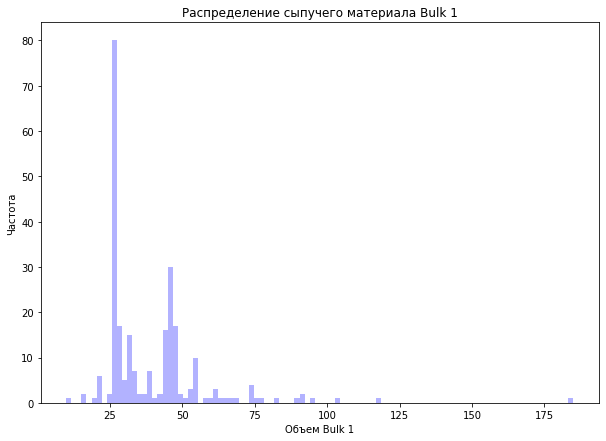

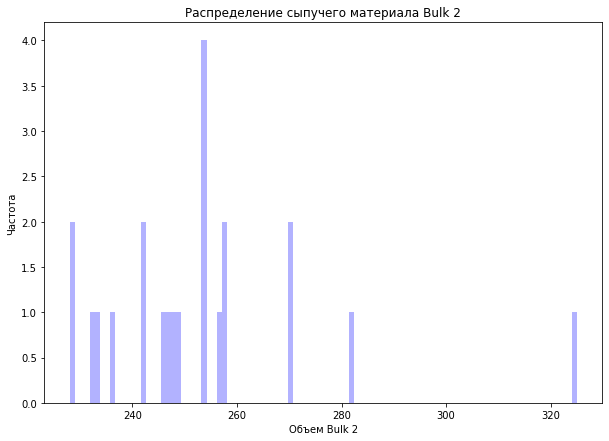

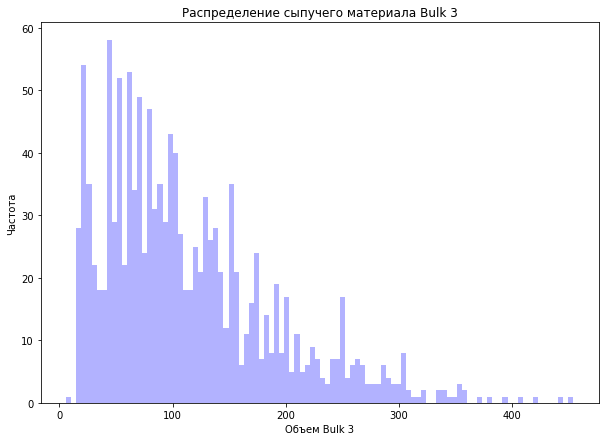

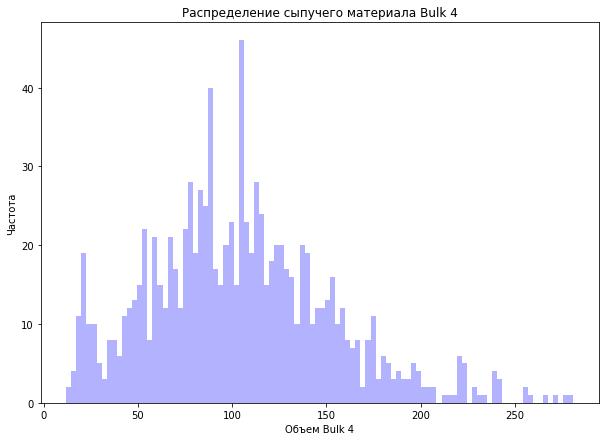

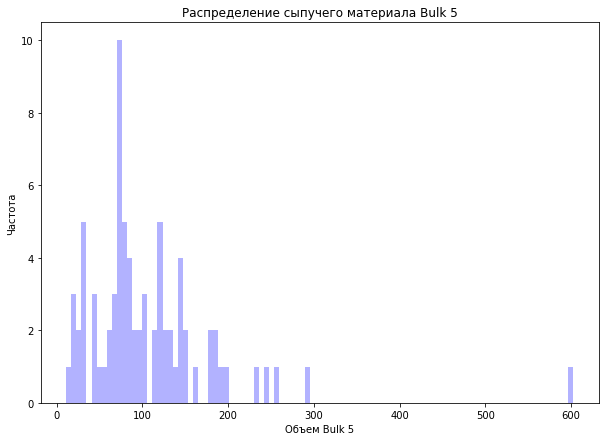

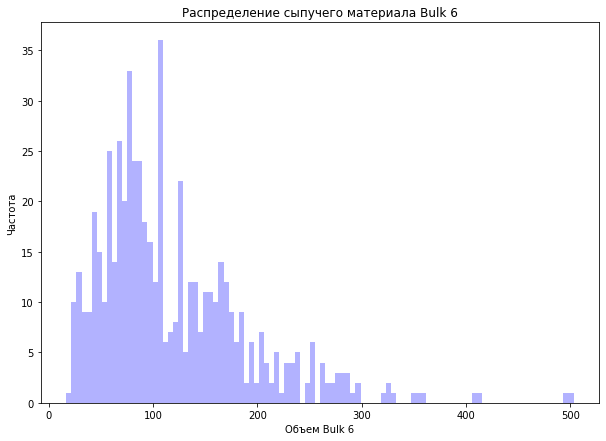

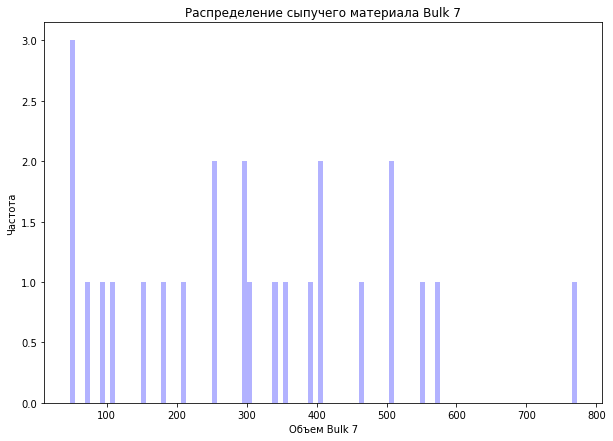

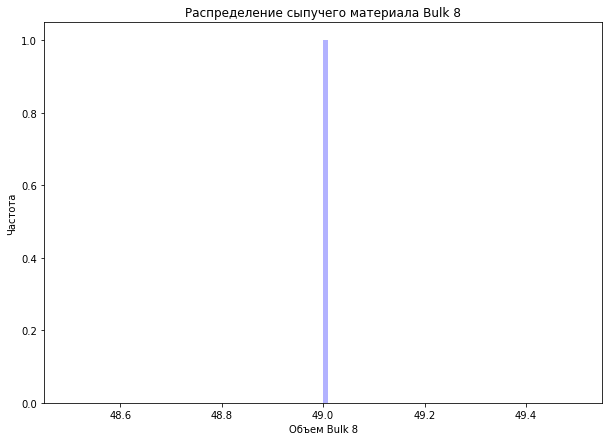

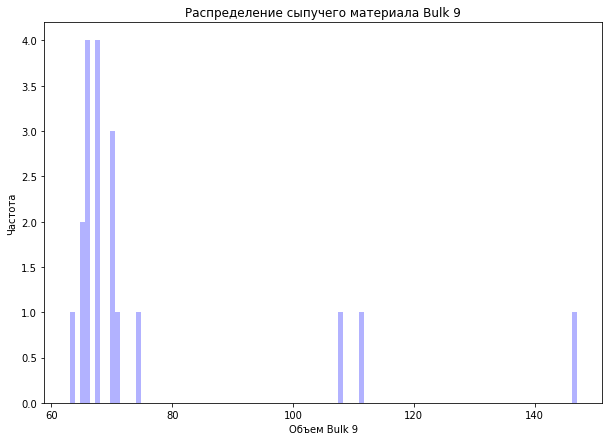

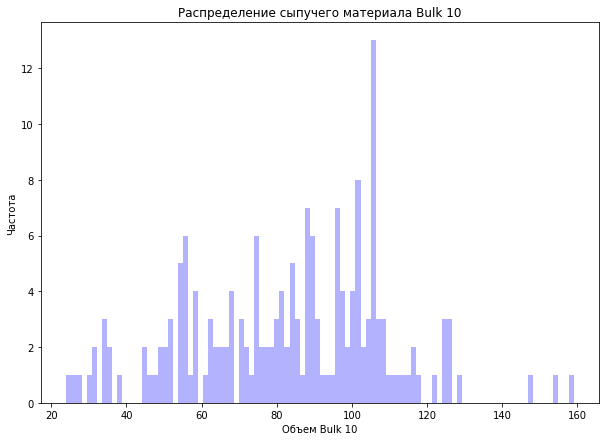

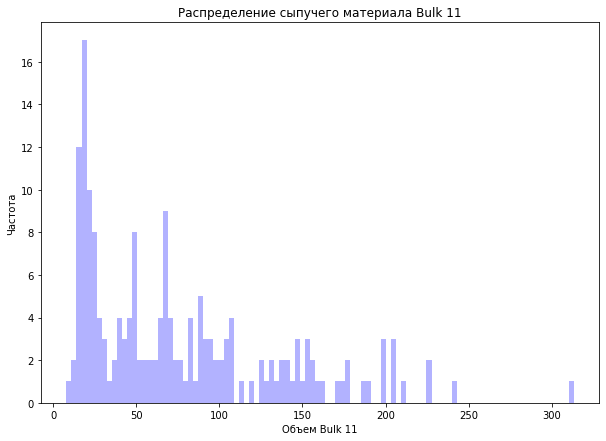

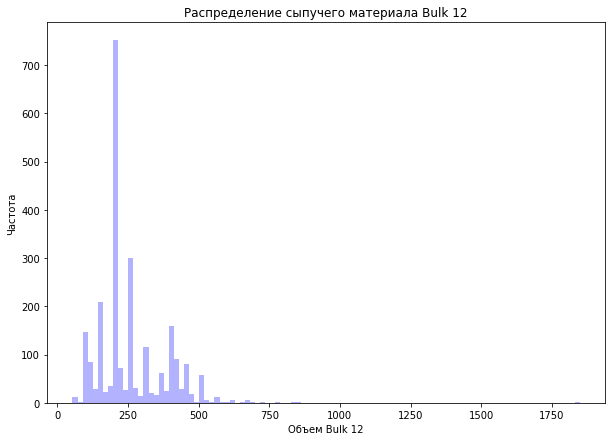

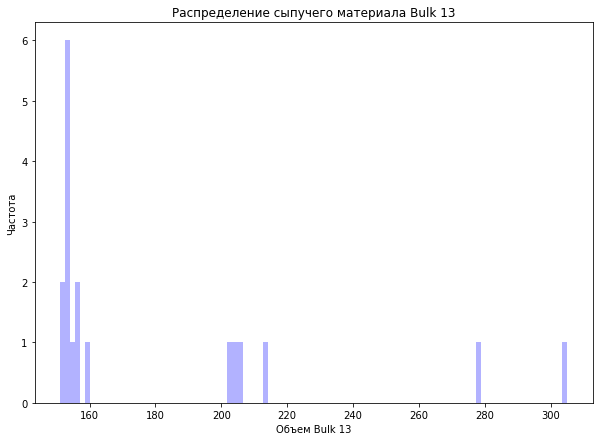

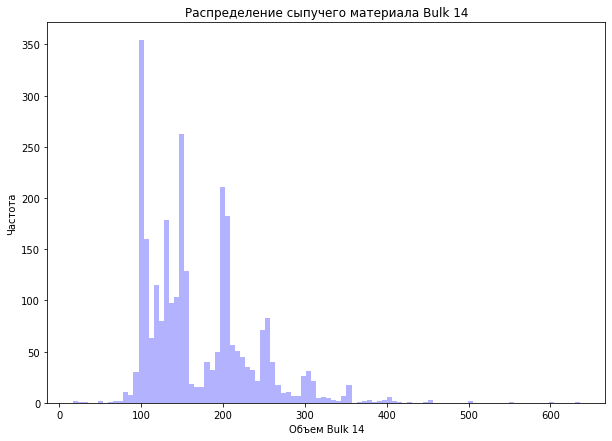

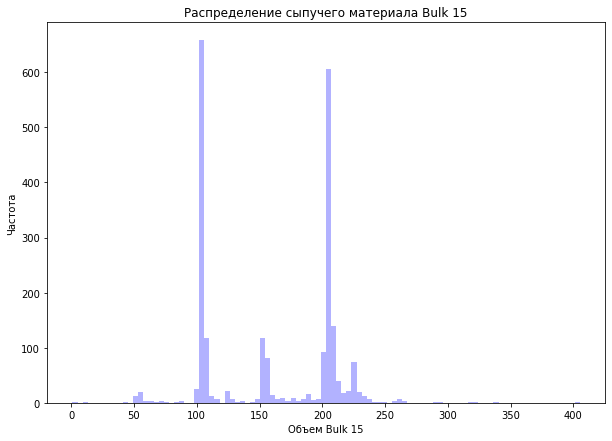

In [24]:
for i in df_bulk_new.drop('key', axis=1):
    ax = df_bulk_new[i].dropna().plot(kind='hist', bins=100, color='blue', alpha=0.3)
    ax.set_title(f'Распределение сыпучего материала {i}')
    ax.set_xlabel(f'Объем {i}')
    ax.set_ylabel('Частота')
    plt.show()

**Вывод по данным об объемах сыпучих материалов:**

Поскольку графики соответствуют не одному непрерывному процессу, а разрозненным значениям, то говорить о распределении сложно. Но в целом можно сказать, что чаще добавляют малое количество сыпучих материалов, об этом свидетельствует и статистическая информация из наборов. Также зафиксируем, что добавляют один или несколько видов сыпучих материалов, никогда не добавляют все. Это объясняет пропуски в данных, которые мы позже заменим на 0-е значения. Количество уникальных записей в поле key - 3129, что соответствует общему количеству записей в наборе.

### Время подачи сыпучих материалов - df_bulk_time_new

In [25]:
display(df_bulk_time_new.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


Подсчитаем количество пропусков, дублей, уникальных записей в поле key.

In [26]:
display(df_bulk_time_new.isna().sum())
display(df_bulk_time_new.duplicated().sum())
display(len(df_bulk_time_new['key'].unique().tolist()))

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

0

3129

Пропусков много, дублей нет, уникальных записей - 3129. Пропуски не помешают нам исследовать данные.     
Перейдем к построению графиков.

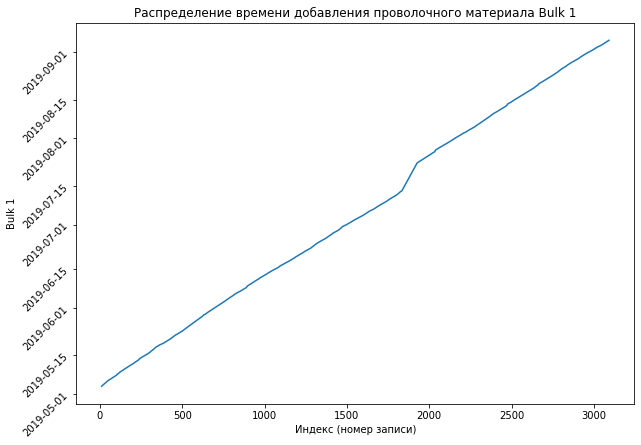

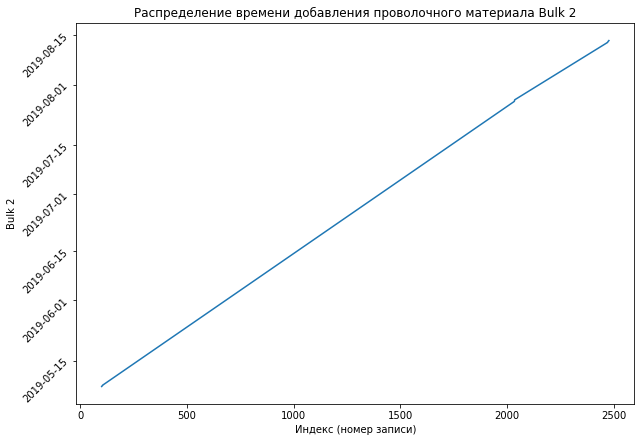

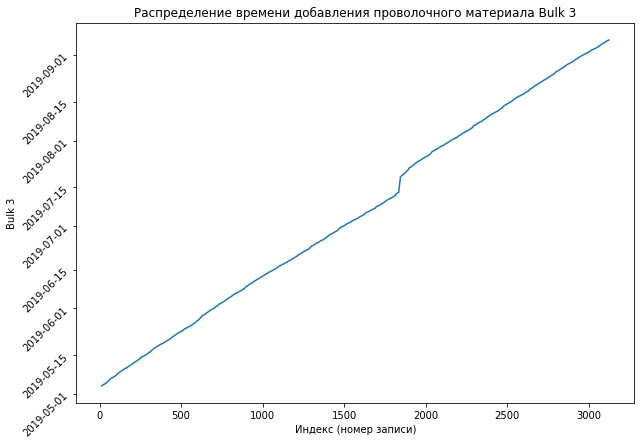

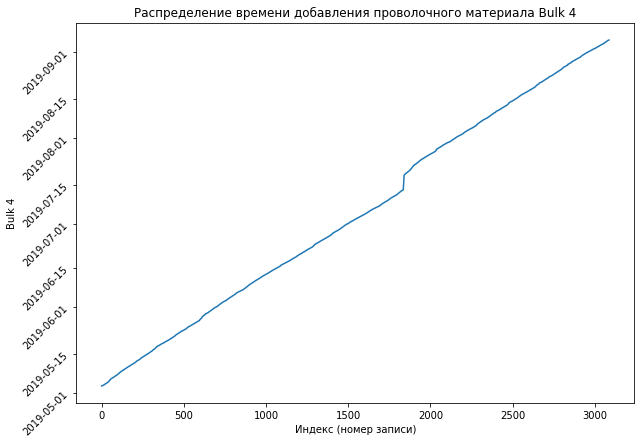

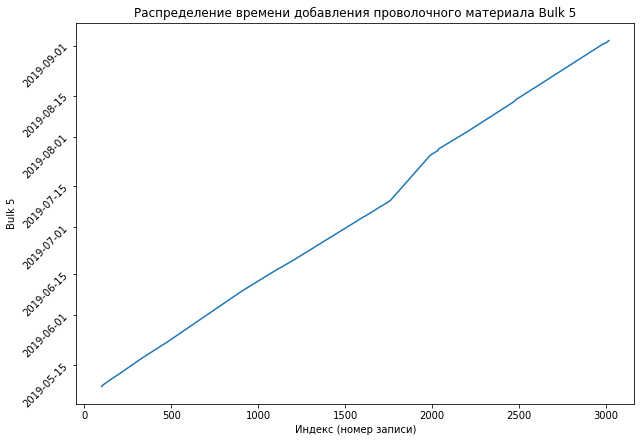

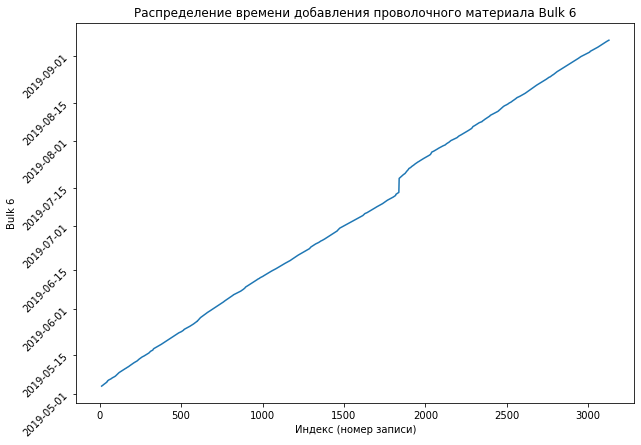

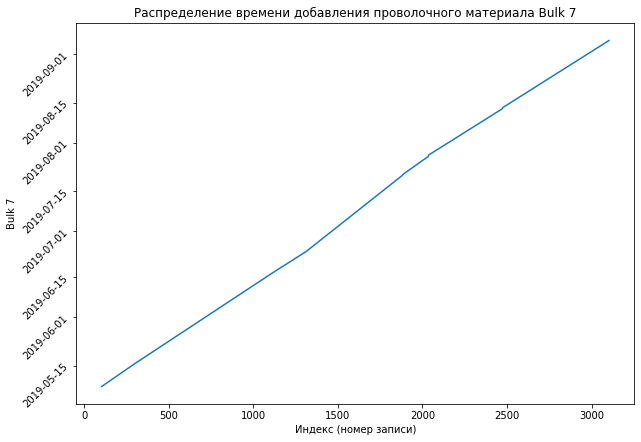

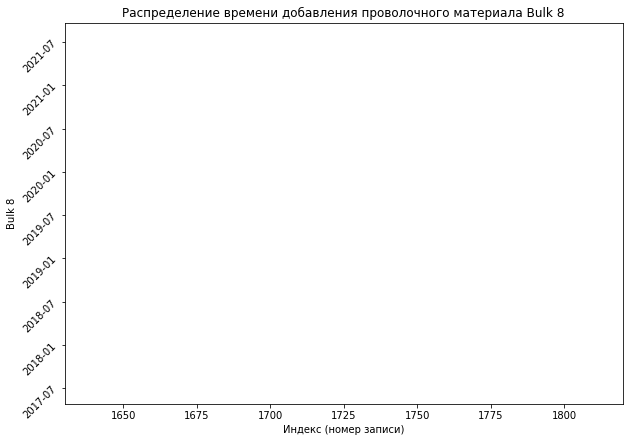

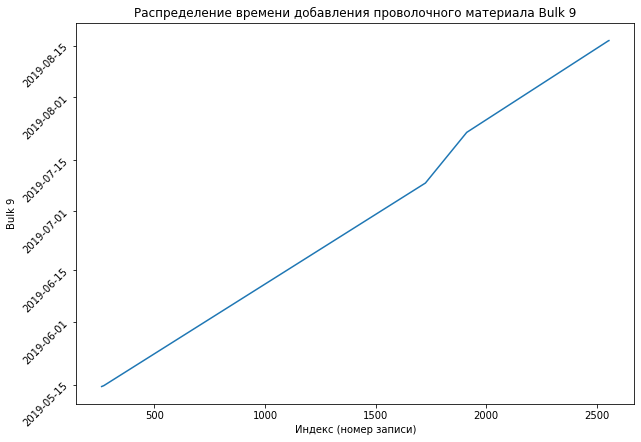

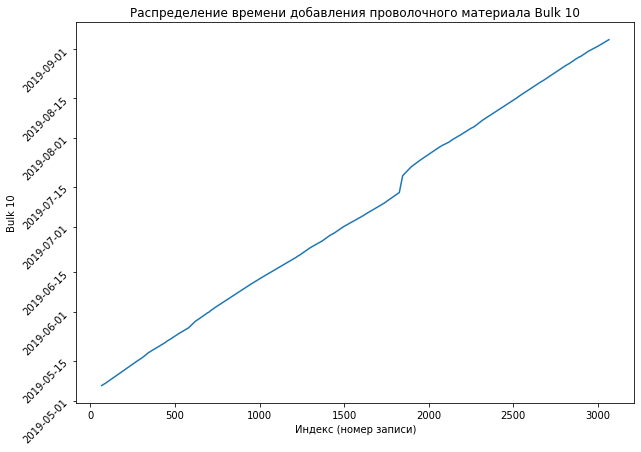

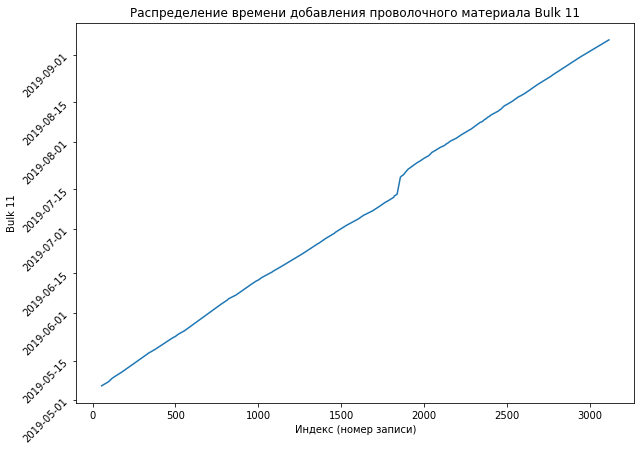

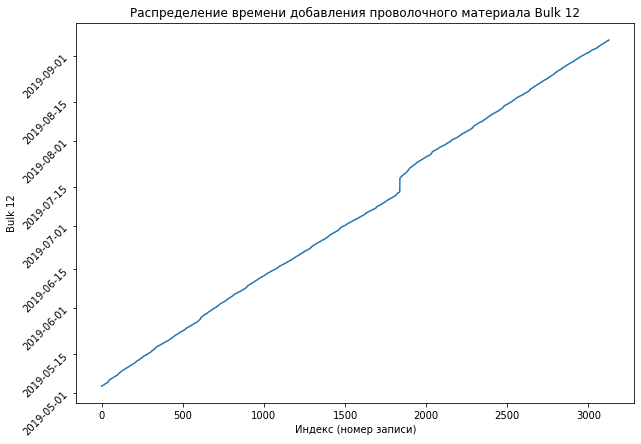

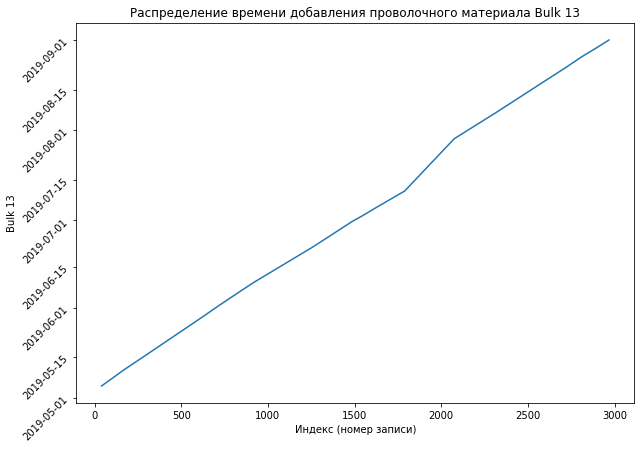

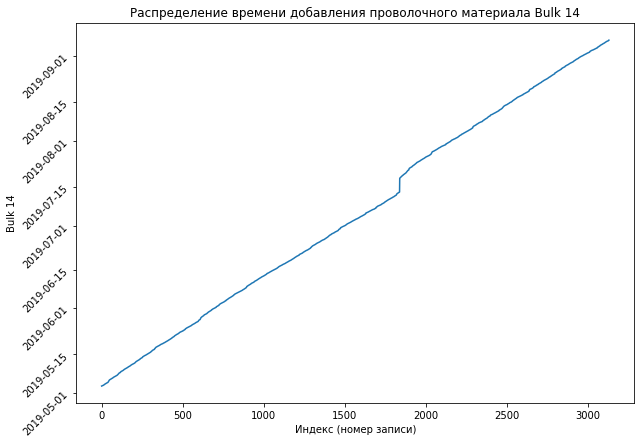

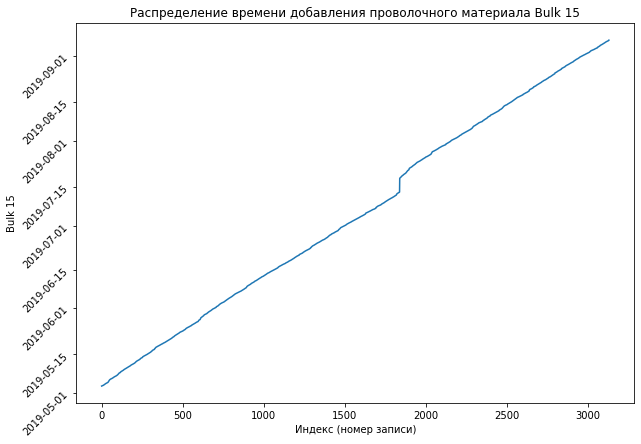

In [27]:
# распределение характеристик времени
for i in df_bulk_time_new.select_dtypes(include=['datetime64']):
    ax = df_bulk_time_new[i].dropna().plot()
    ax.set_title(f'Распределение времени добавления проволочного материала {i}')
    ax.set_ylabel(f'{i}')    
    ax.set_xlabel('Индекс (номер записи)')
    plt.yticks(rotation=45)
    plt.show()

**Выводы по времени подачи сыпучих материалов**     
Большой разрыв по времени, обнаруженный нами при исследовании данных о нагреве дуги, присутствует и в данных о подаче сыпучих материалов, так что похоже, что это штатная ситуация и перерыв при фиксации данных имел место.     
Дублей в данных нет, пропуски есть и связаны они с тем, что в каждой партии количество видов, добавляемых сыпучих материалов различается. Уникальных записей в поле key - 3129, что соответствует количеству записей в наборе данных.

### Данные об объемах газа, подаваемого для продувки сплава - df_gas_new

In [28]:
display(df_gas_new.head())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Подсчитаем количество пропусков, дублей и уникальных записей в колонке key.

In [29]:
display(df_gas_new.isna().sum())
display(df_gas_new.duplicated().sum())
display(len(df_gas_new['key'].unique().tolist()))

key      0
Газ 1    0
dtype: int64

0

3239

Данные идеальны - ни пропусков, ни дублей. Уникальных записей в колонке key - 3239.     
Посмотрим на статистику и переходим к построению графиков.

In [30]:
display(df_gas_new.describe())

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


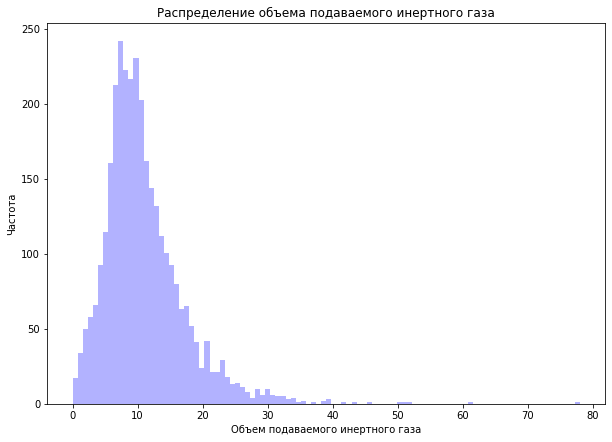

In [31]:
ax = df_gas_new['Газ 1'].plot(kind='hist', bins=100, color='blue', alpha = 0.3)
ax.set_title('Распределение объема подаваемого инертного газа')
ax.set_xlabel('Объем подаваемого инертного газа')
ax.set_ylabel('Частота')
plt.show()

Распределение нормальное, смещено влево. Такое же смещение мы видели на распределении мощностей при нагреве электродов.     
Присутствуют выбросы в виде больших значений объемов - на интервале 40-80, а также в районе 20.

**Выводы по данным об объемах газа, который подается для продувки сплава**     
Данные адекватные, пропуски отсутствуют, дубли отсутсвуют, количество уникальных записей в колонке key - 3239, что соответствует общему количеству записей в наборе. Данные распределены нормально и имеют смещение влево. Пропуски и  дубли отсутствуют.

### Результаты измерения температуры сплава - df_temp_new

In [32]:
display(df_temp_new.head())

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Подсчитаем количество пропусков, дублей и уникальных записей в колонке key.

In [33]:
display(df_temp_new.isna().sum())
display(df_temp_new.duplicated().sum())
display(len(df_temp_new['key'].unique().tolist()))

key                0
Время замера       0
Температура     3427
dtype: int64

0

3216

Дублей нет, а пропусков много. Уникальных значений в колонке key - 3216. Не будем удалять пропуски сейчас, сделаем это после объединения наборов.    
Выведем статистику и построим графики распределения температуры.

In [34]:
display(df_temp_new.describe())

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


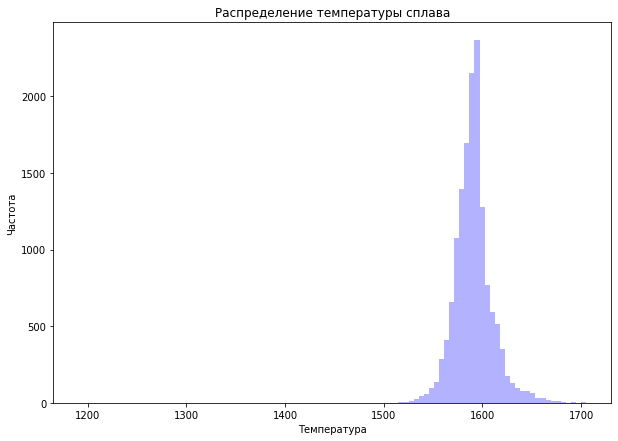

In [35]:
ax = df_temp_new['Температура'].plot(kind='hist', bins=100, color='blue', alpha=0.3)
ax.set_title('Распределение температуры сплава')
ax.set_xlabel('Температура')
ax.set_ylabel('Частота')
plt.show()

Распределение температур нормальное, почти симметричное с небольшим смещением влево.      
Из графика и статистических данных измерений видно, что распределение температур лежит в диапазоне от 1500 до 1700.
Температура плавления стали = 1500, поэтому удалим записи, в которых этот показатель ниже.     
Предварительно подсчитаем количество записей для партий, внутри которых мы будем удалять записи.

In [36]:
for i in df_temp_new[df_temp_new['Температура']<1500]['key']:
    display(df_temp_new[df_temp_new['key']==i].agg(num = ('key','count')))

,key
num,8


,key
num,4


,key
num,3


,key
num,6


,key
num,6


Количество замеров внутри этих партий больше 1, так что удаляем записи, где температура была меньше 1500.

In [37]:
df_temp_new_drop = df_temp_new.drop(df_temp_new[df_temp_new['Температура']<1500].index, axis=0)
display(df_temp_new_drop.head())
display(df_temp_new_drop.describe())

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,Температура
count,18087.000000,14660.000000
mean,1616.448222,1590.852729
std,934.717170,19.143141
min,1.000000,1515.000000
25%,807.000000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


До удаления записей было 18092, после удаления 5 строк - 18087. Удаление прошло корректно.

**Выводы по измерениям температуры**

Данные имеют нормальное распределение с небольшим смещением влево. Аномалии наблюдаются слева, поэтому принято решение удалить записи, где значение температуры меньше температуры плавления стали (1500). Дубли отсутствуют, пропуски есть, заполним их позже. Уникальных значений в колонке key - 3216.

### Объемы проволочных материалов - data_wire_new

In [38]:
display(df_wire_new.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Подсчитаем количество пропусков и проверим наличие нулевых значений, как поступили с сыпучими материалами.

In [39]:
for i in df_wire_new:
    display(f'В колонке {i} {round(df_wire_new[df_wire_new[i]==0][i].sum())} нулевых значений')

'В колонке key 0 нулевых значений'

'В колонке Wire 1 0 нулевых значений'

'В колонке Wire 2 0 нулевых значений'

'В колонке Wire 3 0 нулевых значений'

'В колонке Wire 4 0 нулевых значений'

'В колонке Wire 5 0 нулевых значений'

'В колонке Wire 6 0 нулевых значений'

'В колонке Wire 7 0 нулевых значений'

'В колонке Wire 8 0 нулевых значений'

'В колонке Wire 9 0 нулевых значений'

Нулевые значения отсутствуют, так что подсчитаем количество пропусков и дубликатов, а также количество уникальных значений в колонке key.

In [40]:
display(df_wire_new.isna().sum())
display(df_wire_new.duplicated().sum())
display(len(df_wire_new['key'].unique().tolist()))

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

0

3081

Дублей нет, а пропуски не помешают нам исследовать данные. Уникальных значений в колонке key - 3081.      
Построим графики для всех видов проволочных материалов.

In [41]:
display(df_wire_new.head())
display(df_wire_new.describe())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


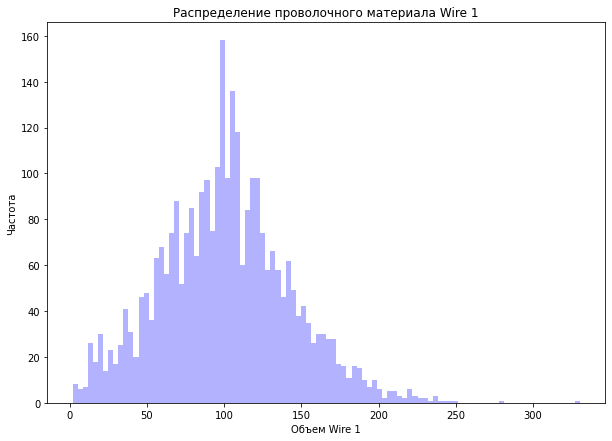

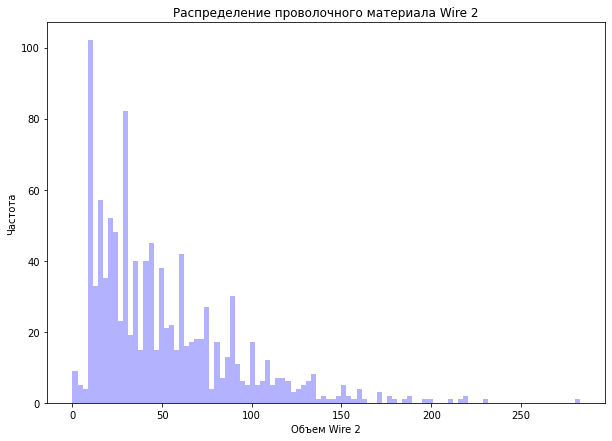

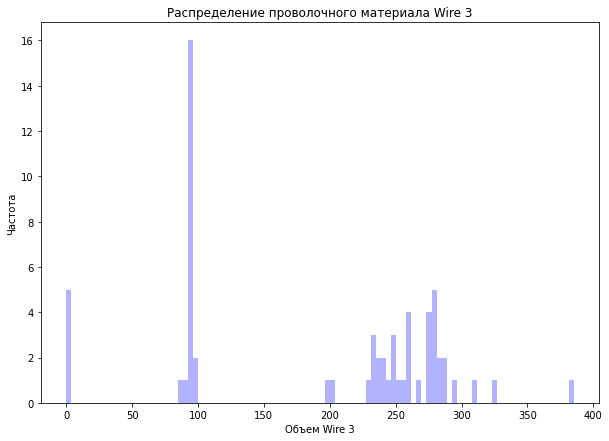

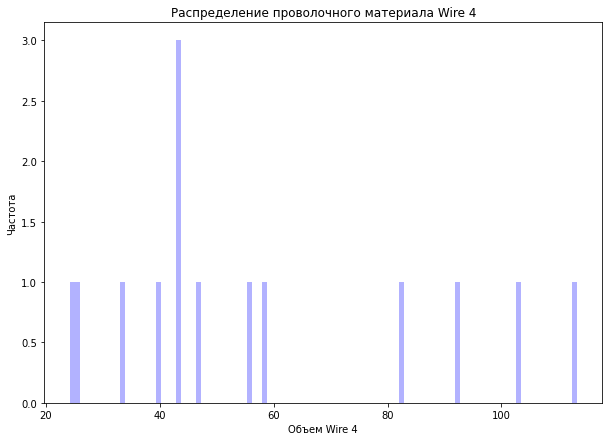

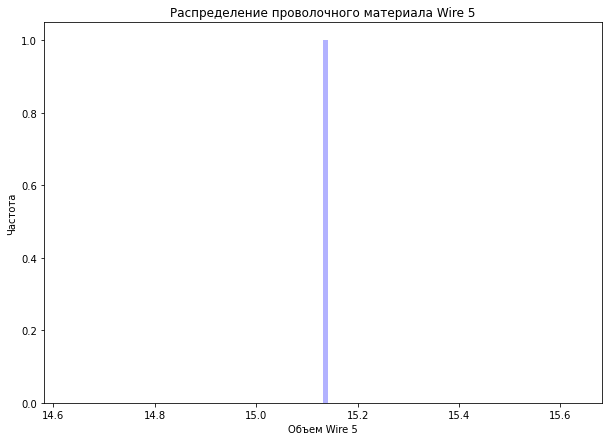

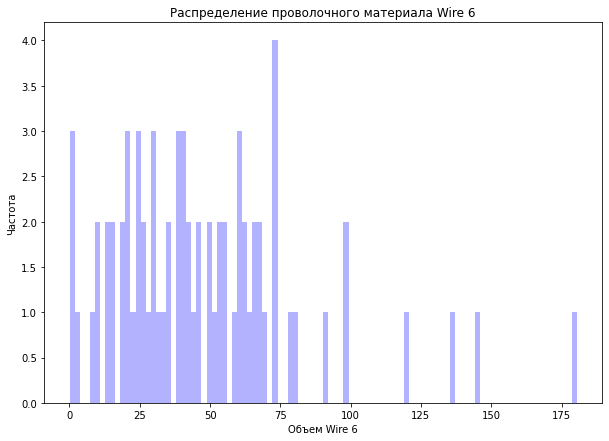

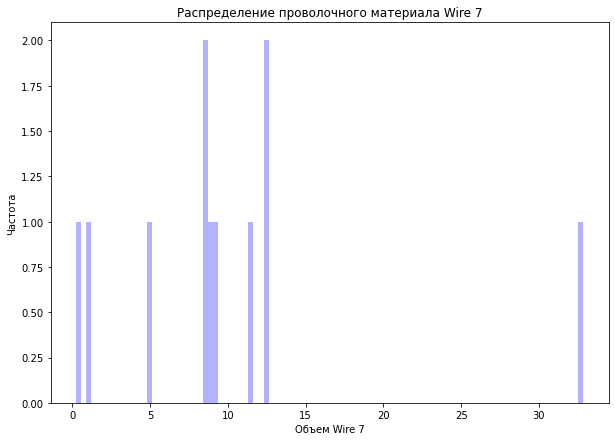

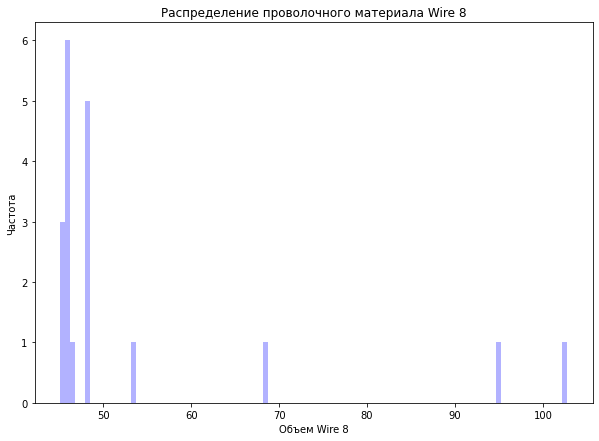

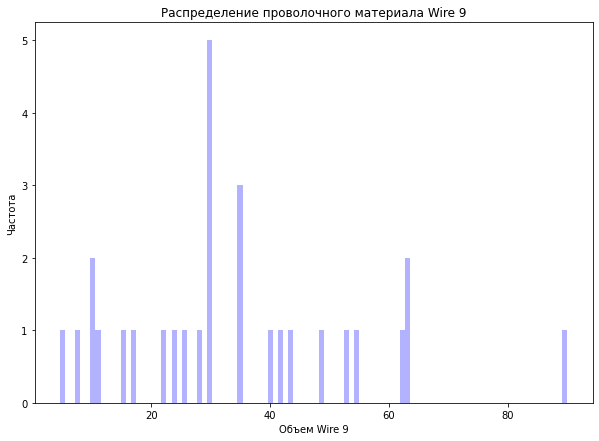

In [42]:
for i in df_wire_new.drop('key', axis=1):
    ax = df_wire_new[i].plot(kind='hist', bins=100, color='blue', alpha=0.3)
    ax.set_title(f'Распределение проволочного материала {i}')
    ax.set_xlabel(f'Объем {i}')
    ax.set_ylabel('Частота')
    plt.show()

В поле key пропусков нет, поэтому заменяем их 0, не отбрасывая поле key.

In [43]:
display(df_wire_new.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Выводы по объемам проволочных материалов**

Поскольку графики соответствуют не одному непрерывному процессу, а разрозненным значениям, то говорить о распределении сложно. Но в целом можно сказать, что чаще добавляют малое количество проволчных материалов, об этом свидетельствует и статистическая информация из наборов. Также зафиксируем, что добавляют один или несколько видов проволочных материалов, никогда не добавляют все. Это объясняет пропуски в данных, которые мы позже заменим на 0-е значения. Количество уникальных записей в поле key - 3081, что соответствует общему количеству записей в наборе

### Время подачи проволочных материалов - data_wire_time_new

In [44]:
display(df_wire_time_new.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Подсчитаем количество пропусков, дублей и уникальных значений в поле key - 3081.

In [45]:
display(df_wire_time_new.isna().sum())
display(df_wire_time_new.duplicated().sum())
display(len(df_wire_time_new['key'].unique().tolist()))

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

0

3081

Пропусков много, дублей нет. Уникальных значений в поле key - 3081. Пропуски не помешают нам исследовать данные. Перейдем к построению графиков.

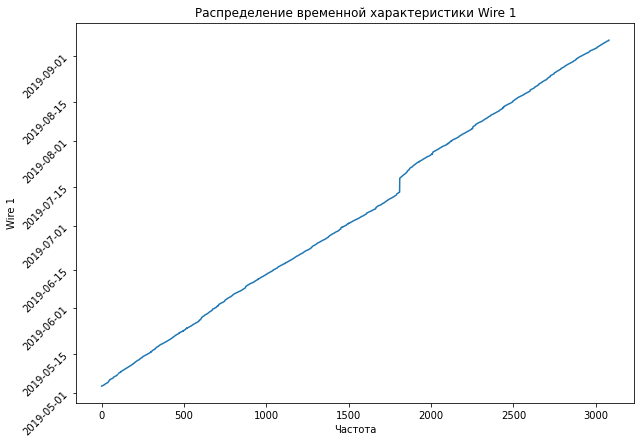

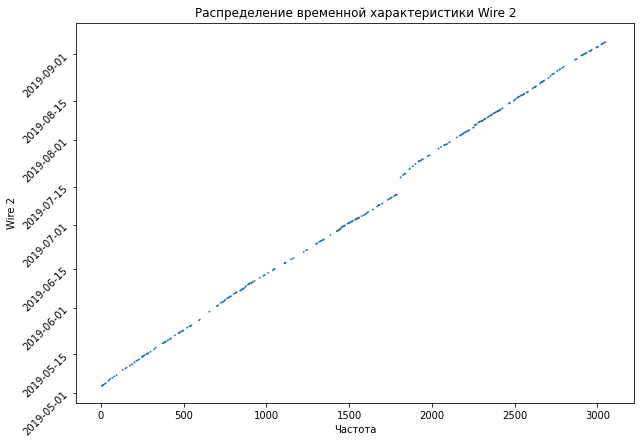

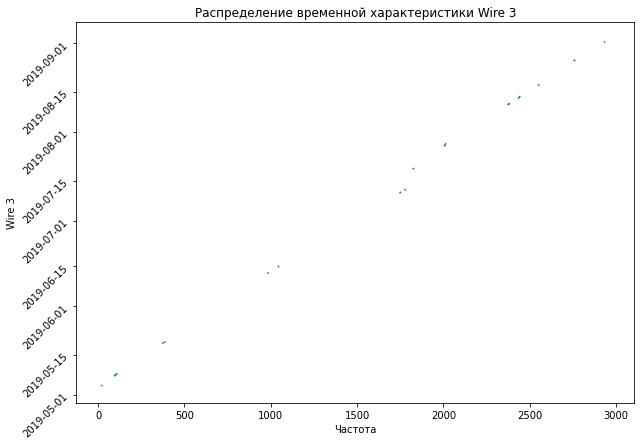

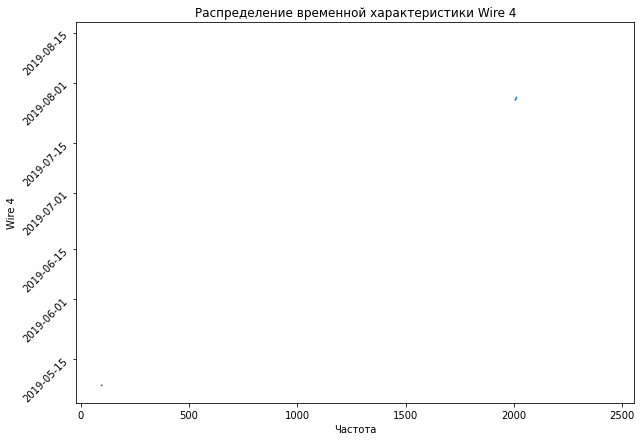

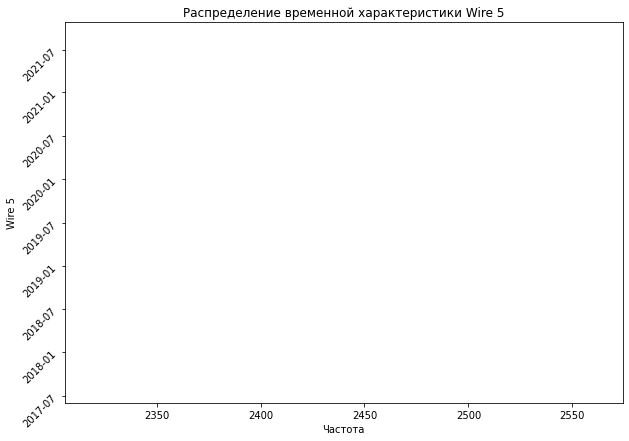

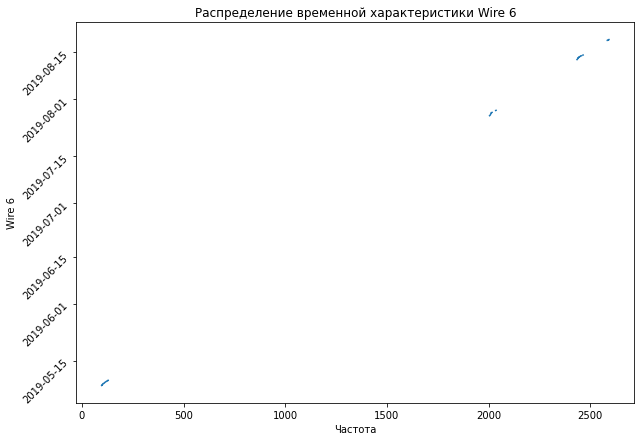

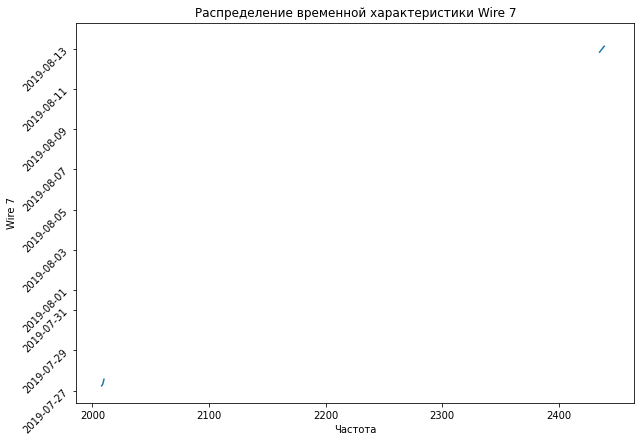

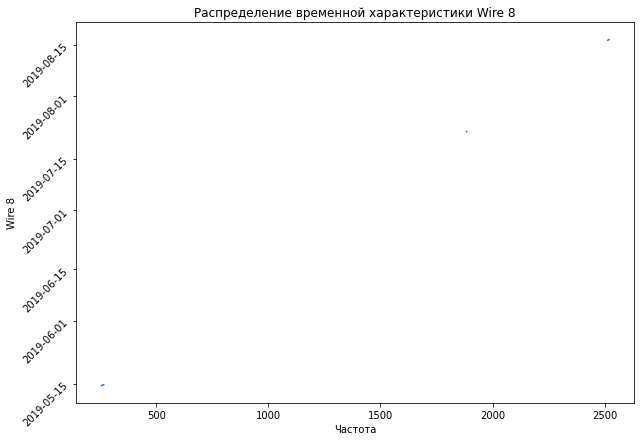

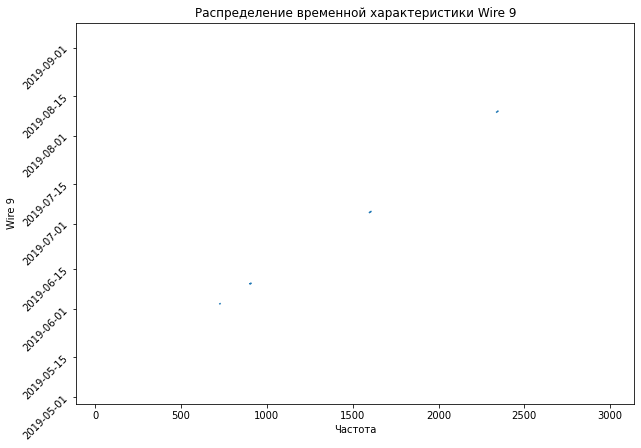

In [46]:
# распределение характеристик времени
for i in df_wire_time_new.select_dtypes(include=['datetime64']):
    ax = df_wire_time_new[i].plot()
    ax.set_title(f'Распределение временной характеристики {i}')
    ax.set_ylabel(f'{i}')    
    ax.set_xlabel('Частота')
    plt.yticks(rotation=45)
    plt.show()

**Выводы по времени подачи проволочных материалов**      
Большой разрыв по времени, обнаруженный нами при исследовании данных о нагреве дуги, присутствует и в данных о подаче сыпучих материалов, так что похоже, что это штатная ситуация и перерыв при фиксации данных имел место.
Дублей в данных нет, пропуски есть и связаны они с тем, что в каждой партии количество видов, добавляемых сыпучих материалов различается. Уникальных записей в поле key - 3081, что соответствует количеству записей в наборе.

**ОБЩИЕ ВЫВОДЫ по 7-ми наборам**     
В результате исследования данных выяснили:    
- уникальных значений в поле key набора о нагреве электродов - 3214, дубли и пропуски отсутствуют, данные имеют нормально распределение со смещением влево;
- уникальных значений в поле key набора о проволочных материалах и времени их подачи - 3129, чаще добавляют один или несколько видов проволочных материалов, никогда не добавляют все, поэтому пропуски в данных есть, дубли отсутствуют;
- уникальных записей в колонке key набора о подаче инертного газа - 3239, дубли и пропуски отсутствуют, данные имеют нормальное распределение, которое по аналогии с мощностью смещено влево;
- уникальных значений в колонке key набора с измерениями температуры - 3216, дубли отсутствуют, пропуски есть, из набора удалены записи с температурой плавления меньше 1500 (температура плавления стали);
- уникальных значений в поле key набора о проволочных материалах и времени их подачи - 3081, чаще добавляют один или несколько видов сыпучих материалов, никогда не добавляют все, поэтому пропуски в данных есть, дубли отсутствуют.

Пропуски в данных о материалах заменим 0-выми значениями, данные с повторяющимися ключами агрегируем перед объединением.

## Объединение данных

Перед объединением 7-ми наборов в один по общему ключу key проведем преобразование данных для 4-х наборов:     
- результаты измерения мощности нагрева электродов,
- результаты измерения температуры сплава,
- добавляемых сыпучих и проволочных материалах.

### Результаты измерения мощности нагрева электродов

Сформируем из исходного новый набор данных, который будет состоять из следующих колонок:
- **key** - уникальный номер партии,
- **act_power** - суммарная активная мощность для одной партии,
- **react_power** - суммарная реактивная мощность для одной партии,
- **sum_full_power** - суммарная мощность для одной партии,
- **power_iter** - количество измерений в каждой партии,
- **heat_first_start** - суммарная продолжительность в секундах,
- **heat_last_end** - суммарная продолжительность в секундах,
- **sum_heat_duration** - суммарная продолжительность в секундах.

Рассчитаем новое значение *полной мощности S (full_power)* по формуле:     
    sqrt(PхP + QxQ), где    
    P - активная мощность,     
    Q - реактивная мощность.

In [47]:
# переименуем колонки
df_arc_new_agg = df_arc_new.rename(columns={'Активная мощность':'act_power',
                                            'Реактивная мощность':'react_power',
                                            'Начало нагрева дугой':'heat_start',
                                            'Конец нагрева дугой':'heat_end'})
df_arc_new_agg['power'] = round((df_arc_new_agg['act_power']**2 + df_arc_new_agg['react_power']**2)**0.5,6)

In [48]:
df_arc_new_agg['heat_duration'] = (df_arc_new_agg['heat_end']-df_arc_new_agg['heat_start']).astype('timedelta64[s]')
display(df_arc_new_agg.head())

,key,heat_start,heat_end,act_power,react_power,power,heat_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0


In [49]:
df_arc_new_agg = (df_arc_new_agg.groupby('key', as_index=False)
                  .agg(sum_act_power = ('act_power', 'sum'),
                       sum_react_power = ('react_power', 'sum'),
                       sum_power = ('power', 'sum'),
                       power_iter = ('power', 'count'),
                       heat_first_start = ('heat_start', 'min'),
                       heat_last_end = ('heat_end','max'),
                       sum_heat_duration = ('heat_duration', 'sum')))
df_arc_new_agg = df_arc_new_agg.set_index('key', drop=True)

In [50]:
display(df_arc_new_agg.head())
display(df_arc_new_agg.info())

,sum_act_power,sum_react_power,sum_power,power_iter,heat_first_start,heat_last_end,sum_heat_duration
key,,,,,,,
1,3.036730,2.142821,3.718736,5,2019-05-03 11:02:14,2019-05-03 11:28:37,1098.0
2,2.139408,1.453357,2.588349,4,2019-05-03 11:34:14,2019-05-03 11:53:18,811.0
3,4.063641,2.937457,5.019224,5,2019-05-03 12:06:54,2019-05-03 12:32:19,655.0
4,2.706489,2.056992,3.400038,4,2019-05-03 12:39:37,2019-05-03 12:57:50,741.0
5,2.252950,1.687991,2.816980,4,2019-05-03 13:11:13,2019-05-03 13:33:55,869.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sum_act_power      3214 non-null   float64       
 1   sum_react_power    3214 non-null   float64       
 2   sum_power          3214 non-null   float64       
 3   power_iter         3214 non-null   int64         
 4   heat_first_start   3214 non-null   datetime64[ns]
 5   heat_last_end      3214 non-null   datetime64[ns]
 6   sum_heat_duration  3214 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 200.9 KB


None

Пустых данных нет, считаем, что преобразование выполнено корректно.

### Результаты измерения температуры

Сформируем из исходного новый набор данных, который будет состоять из следующих колонок:
- **key** - уникальный номер партии,
- **min_time** - минимальное время измерений температуры,
- **max_time** - максимальное время измерений температуры,
- **temp_start** - температура, соответствующая минимальному времени нагрева электродов внутри партии,
- **temp_end** - температура, соответствующая максимальному времени нагрева электродов внутри партии,
- **splav_time** - дельта между максимальным и минимальным временем нагрева электродов внутри партии,
- **temp_iter** - количество измерений температуры в одной партии.

Отфильтруем требуемые данные из исходного набора df_temp_new и объединим в новый набор.

Переименуем столбцы

In [51]:
df_temp_new_agg = df_temp_new_drop.rename(columns={'Время замера':'time','Температура': 'temp'})
display(df_temp_new_agg.head())

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [52]:
# находим время старта и окончания в серии
time_min_max = (df_temp_new_agg.groupby('key')
                .agg(min_time=('time','min'), max_time=('time','max')))

# по найденному времени делаем выборки температур и времени
tmp_min_temp = df_temp_new_agg.loc[df_temp_new_agg['time'].isin(time_min_max['min_time'])]

# меняем индекс на key
tmp_min_temp = tmp_min_temp.set_index('key', drop=True)
tmp_min_temp = tmp_min_temp.rename(columns={'time':'min_time', 'temp':'temp_start'})

# по найденному времени делаем выборки температур и времени
tmp_max_temp = df_temp_new_agg.loc[df_temp_new_agg['time'].isin(time_min_max['max_time'])]
tmp_max_temp = tmp_max_temp.rename(columns={'time':'max_time', 'temp':'temp_end'})

# меняем индекс на key
tmp_max_temp = tmp_max_temp.set_index('key', drop=True)

# выисляем число итераций
tmp_temp_count = df_temp_new_agg.groupby('key').agg(temp_iter=('temp','count'))

In [53]:
display(time_min_max.head())
display(tmp_min_temp.head())
display(tmp_max_temp.head())

,min_time,max_time
key,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38
2,2019-05-03 11:34:04,2019-05-03 11:55:09
3,2019-05-03 12:06:44,2019-05-03 12:35:57
4,2019-05-03 12:39:27,2019-05-03 12:59:47
5,2019-05-03 13:11:03,2019-05-03 13:36:39


,min_time,temp_start
key,,
1,2019-05-03 11:02:04,1571.0
2,2019-05-03 11:34:04,1581.0
3,2019-05-03 12:06:44,1596.0
4,2019-05-03 12:39:27,1601.0
5,2019-05-03 13:11:03,1576.0


,max_time,temp_end
key,,
1,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:36:39,1602.0


In [54]:
df_temp_new_agg=(tmp_min_temp
                .merge(tmp_max_temp, on='key')
                .merge(tmp_temp_count, on='key'))
df_temp_new_agg['splav_time'] = (df_temp_new_agg['max_time']-df_temp_new_agg['min_time']).astype('timedelta64[s]')
#df_temp_new_agg = df_temp_new_agg.set_index('key', drop=True)

In [55]:
display(df_temp_new_agg.head())
display(df_temp_new_agg.info())

,min_time,temp_start,max_time,temp_end,temp_iter,splav_time
key,,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,6,1714.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,5,1265.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,6,1753.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,5,1220.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,5,1536.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   min_time    3216 non-null   datetime64[ns]
 1   temp_start  3215 non-null   float64       
 2   max_time    3216 non-null   datetime64[ns]
 3   temp_end    2477 non-null   float64       
 4   temp_iter   3216 non-null   int64         
 5   splav_time  3216 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 175.9 KB


None

In [56]:
display(df_temp_new_agg.head())
display(df_temp_new_agg.info())

,min_time,temp_start,max_time,temp_end,temp_iter,splav_time
key,,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,6,1714.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,5,1265.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,6,1753.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,5,1220.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,5,1536.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   min_time    3216 non-null   datetime64[ns]
 1   temp_start  3215 non-null   float64       
 2   max_time    3216 non-null   datetime64[ns]
 3   temp_end    2477 non-null   float64       
 4   temp_iter   3216 non-null   int64         
 5   splav_time  3216 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 175.9 KB


None

Видим, что есть пустые строки, но они были и до преобразования. Сейчас мы эти строки можем удалить, потому что именно в этой таблице содержится наш целевой показатель - конечная температура.
Выведем эти строки.

In [57]:
display(df_temp_new_agg[df_temp_new_agg['temp_start'].isna()|
                         df_temp_new_agg['temp_end'].isna()|
                         df_temp_new_agg['temp_iter'].isna()])
display(df_temp_new_agg[df_temp_new_agg['temp_start'].isna()|
                        df_temp_new_agg['temp_end'].isna()|
                        df_temp_new_agg['temp_iter'].isna()].count())

,min_time,temp_start,max_time,temp_end,temp_iter,splav_time
key,,,,,,
2500,2019-08-10 14:04:39,1539.0,2019-08-10 14:29:39,NaN,1,1500.0
2501,2019-08-10 14:41:14,1587.0,2019-08-10 15:29:00,NaN,1,2866.0
2502,2019-08-10 15:39:39,1583.0,2019-08-10 16:04:55,NaN,1,1516.0
2503,2019-08-10 16:27:44,1603.0,2019-08-10 17:14:24,NaN,1,2800.0
2504,2019-08-10 17:31:43,1583.0,2019-08-10 18:03:42,NaN,1,1919.0
...,...,...,...,...,...,...
3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:55:45,NaN,1,1470.0
3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:34:37,NaN,1,1102.0
3239,2019-09-06 14:16:50,1598.0,2019-09-06 15:09:55,NaN,1,3185.0


min_time      739
temp_start    738
max_time      739
temp_end        0
temp_iter     739
splav_time    739
dtype: int64

То есть всего 27 записей, для которых одновременно отсутствуют данные о температуре. Удалим их. 

In [58]:
df_temp_new_drop = df_temp_new_agg.drop(df_temp_new_agg[df_temp_new_agg['temp_start'].isna()|
                                        df_temp_new_agg['temp_end'].isna()|
                                        df_temp_new_agg['temp_iter'].isna()].index, axis=0)
display(df_temp_new_drop.info())
display(df_temp_new_drop.head())
display(df_temp_new_drop.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   min_time    2477 non-null   datetime64[ns]
 1   temp_start  2477 non-null   float64       
 2   max_time    2477 non-null   datetime64[ns]
 3   temp_end    2477 non-null   float64       
 4   temp_iter   2477 non-null   int64         
 5   splav_time  2477 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 135.5 KB


None

,min_time,temp_start,max_time,temp_end,temp_iter,splav_time
key,,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,6,1714.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,5,1265.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,6,1753.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,5,1220.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,5,1536.0


,min_time,temp_start,max_time,temp_end,temp_iter,splav_time
key,,,,,,
2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0,5,1380.0
2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0,7,1705.0
2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0,4,962.0
2498,2019-08-10 12:58:11,1591.0,2019-08-10 13:23:31,1594.0,6,1520.0
2499,2019-08-10 13:33:21,1569.0,2019-08-10 13:58:58,1603.0,5,1537.0


Дополнительно заказчик попросил нас удалить строки, где было только 1 измерений температуры. Подсчитаем, сколько таких строк, посмотрим на них и удалим.

In [59]:
display(df_temp_new_drop[df_temp_new_drop['temp_iter']==1])

,min_time,temp_start,max_time,temp_end,temp_iter,splav_time
key,,,,,,
195,2019-05-11 00:01:36,1583.0,2019-05-11 00:01:36,1583.0,1,0.0
279,2019-05-14 10:13:01,1603.0,2019-05-14 10:13:01,1603.0,1,0.0


In [60]:
df_temp_new_drop = df_temp_new_drop.drop(df_temp_new_drop[df_temp_new_drop['temp_iter']==1].index, axis=0)
display(df_temp_new_drop.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   min_time    2475 non-null   datetime64[ns]
 1   temp_start  2475 non-null   float64       
 2   max_time    2475 non-null   datetime64[ns]
 3   temp_end    2475 non-null   float64       
 4   temp_iter   2475 non-null   int64         
 5   splav_time  2475 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 135.4 KB


None

In [61]:
df_temp_new_drop['temp_iter'] = df_temp_new_drop['temp_iter'].astype(int)
display(df_temp_new_drop.info())
display(df_temp_new_drop.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   min_time    2475 non-null   datetime64[ns]
 1   temp_start  2475 non-null   float64       
 2   max_time    2475 non-null   datetime64[ns]
 3   temp_end    2475 non-null   float64       
 4   temp_iter   2475 non-null   int64         
 5   splav_time  2475 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 135.4 KB


None

,min_time,temp_start,max_time,temp_end,temp_iter,splav_time
key,,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,6,1714.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,5,1265.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,6,1753.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,5,1220.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,5,1536.0


### Заменим пропуски в наборах о времени и объемах сыпучих материалов

In [62]:
display(df_bulk_new.info())
display(df_bulk_time_new.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

В поле key пропусков нет, поэтому заменяем их 0, не отбрасывая поле key.

In [63]:
df_bulk_new = df_bulk_new.fillna(0)
display(df_bulk_new.isna().sum())

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

Пропущенные значения в датах заменим на дату, которой точно не будет в наборе, - 2000-12-12

In [64]:
df_bulk_time_new = df_bulk_time_new.fillna(pd.Timestamp('20001212'))
display(df_bulk_time_new.isna().sum())

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

Пропуски заменили, теперь заменим индекс на поле Key и проверим датафрейм.

In [65]:
df_bulk_new = df_bulk_new.set_index('key', drop=True)
display(df_bulk_new.head())
df_bulk_time_new = df_bulk_time_new.set_index('key', drop=True)
display(df_bulk_time_new.head())
display(df_bulk_time_new.info())

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,2000-12-12,2000-12-12,2000-12-12,2019-05-03 11:28:48,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 11:24:31,2000-12-12,2019-05-03 11:14:50,2019-05-03 11:10:43
2,2000-12-12,2000-12-12,2000-12-12,2019-05-03 11:36:50,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 11:53:30,2000-12-12,2019-05-03 11:48:37,2019-05-03 11:44:39
3,2000-12-12,2000-12-12,2000-12-12,2019-05-03 12:32:39,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 12:27:13,2000-12-12,2019-05-03 12:21:01,2019-05-03 12:16:16
4,2000-12-12,2000-12-12,2000-12-12,2019-05-03 12:43:22,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 12:58:00,2000-12-12,2019-05-03 12:51:11,2019-05-03 12:46:36
5,2000-12-12,2000-12-12,2000-12-12,2019-05-03 13:30:47,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 13:30:47,2000-12-12,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Bulk 1   3129 non-null   datetime64[ns]
 1   Bulk 2   3129 non-null   datetime64[ns]
 2   Bulk 3   3129 non-null   datetime64[ns]
 3   Bulk 4   3129 non-null   datetime64[ns]
 4   Bulk 5   3129 non-null   datetime64[ns]
 5   Bulk 6   3129 non-null   datetime64[ns]
 6   Bulk 7   3129 non-null   datetime64[ns]
 7   Bulk 8   3129 non-null   datetime64[ns]
 8   Bulk 9   3129 non-null   datetime64[ns]
 9   Bulk 10  3129 non-null   datetime64[ns]
 10  Bulk 11  3129 non-null   datetime64[ns]
 11  Bulk 12  3129 non-null   datetime64[ns]
 12  Bulk 13  3129 non-null   datetime64[ns]
 13  Bulk 14  3129 non-null   datetime64[ns]
 14  Bulk 15  3129 non-null   datetime64[ns]
dtypes: datetime64[ns](15)
memory usage: 391.1 KB


None

Объединим наборы с данными о проволочных материалах.

In [66]:
df_bulk = df_bulk_new.merge(df_bulk_time_new, on='key', how ='inner', suffixes=('', '_time'))
display(df_bulk.info())
display(df_bulk.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Bulk 1        3129 non-null   float64       
 1   Bulk 2        3129 non-null   float64       
 2   Bulk 3        3129 non-null   float64       
 3   Bulk 4        3129 non-null   float64       
 4   Bulk 5        3129 non-null   float64       
 5   Bulk 6        3129 non-null   float64       
 6   Bulk 7        3129 non-null   float64       
 7   Bulk 8        3129 non-null   float64       
 8   Bulk 9        3129 non-null   float64       
 9   Bulk 10       3129 non-null   float64       
 10  Bulk 11       3129 non-null   float64       
 11  Bulk 12       3129 non-null   float64       
 12  Bulk 13       3129 non-null   float64       
 13  Bulk 14       3129 non-null   float64       
 14  Bulk 15       3129 non-null   float64       
 15  Bulk 1_time   3129 non-null   datetime

None

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,...,Bulk 6_time,Bulk 7_time,Bulk 8_time,Bulk 9_time,Bulk 10_time,Bulk 11_time,Bulk 12_time,Bulk 13_time,Bulk 14_time,Bulk 15_time
key,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 11:24:31,2000-12-12,2019-05-03 11:14:50,2019-05-03 11:10:43
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 11:53:30,2000-12-12,2019-05-03 11:48:37,2019-05-03 11:44:39
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 12:27:13,2000-12-12,2019-05-03 12:21:01,2019-05-03 12:16:16
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 12:58:00,2000-12-12,2019-05-03 12:51:11,2019-05-03 12:46:36
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 13:30:47,2000-12-12,2019-05-03 13:34:12,2019-05-03 13:30:47


Осталось **3129 записей**. Переименуем колонки в итоговом датафрейме и вернем тип данных полям с датой.

In [67]:
df_bulk = df_bulk.rename(columns={
                            'Bulk 1': 'b1', 'Bulk 2': 'b2', 'Bulk 3': 'b3',
                            'Bulk 4': 'b4', 'Bulk 5': 'b5', 'Bulk 6': 'b6',
                            'Bulk 7': 'b7', 'Bulk 8': 'b8', 'Bulk 9': 'b9',
                            'Bulk 10': 'b10', 'Bulk 11': 'b11', 'Bulk 12': 'b12',
                            'Bulk 13': 'b13', 'Bulk 14': 'b14', 'Bulk 15': 'b15',    
                            'Bulk 1_time': 'b1_time', 'Bulk 2_time': 'b2_time',
                            'Bulk 3_time': 'b3_time', 'Bulk 4_time': 'b4_time',
                            'Bulk 5_time': 'b5_time', 'Bulk 6_time': 'b6_time',
                            'Bulk 7_time': 'b7_time', 'Bulk 8_time': 'b8_time',
                            'Bulk 9_time': 'b9_time', 'Bulk 10_time': 'b10_time',
                            'Bulk 11_time': 'b11_time', 'Bulk 12_time': 'b12_time',
                            'Bulk 13_time': 'b13_time', 'Bulk 14_time': 'b14_time',
                            'Bulk 15_time': 'b15_time'   
})
display(df_bulk.head())

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,b6_time,b7_time,b8_time,b9_time,b10_time,b11_time,b12_time,b13_time,b14_time,b15_time
key,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 11:24:31,2000-12-12,2019-05-03 11:14:50,2019-05-03 11:10:43
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 11:53:30,2000-12-12,2019-05-03 11:48:37,2019-05-03 11:44:39
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 12:27:13,2000-12-12,2019-05-03 12:21:01,2019-05-03 12:16:16
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 12:58:00,2000-12-12,2019-05-03 12:51:11,2019-05-03 12:46:36
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2019-05-03 13:30:47,2000-12-12,2019-05-03 13:34:12,2019-05-03 13:30:47


### Заменим пропуски в наборах о времени и объемах проволочных материалов

In [68]:
display(df_wire_new.info())
display(df_wire_time_new.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

В поле key пропусков нет, поэтому заменяем пропуски на 0, не отбрасывая поле key.

In [69]:
df_wire_new = df_wire_new.fillna(0)
display(df_wire_new.isna().sum())

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

Пропущенные значения в датах заменим на дату, которой точно не будет в наборе, - 2000-12-12

In [70]:
df_wire_time_new = df_wire_time_new.fillna(pd.Timestamp('20001212'))
display(df_wire_time_new.isna().sum())

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

Пропуски заменили, теперь заменим индекс на поле key и проверим датафрейм.

In [71]:
df_wire_new = df_wire_new.set_index('key', drop=True)
df_wire_time_new = df_wire_time_new.set_index('key', drop=True)
display(df_wire_new.head())
display(df_wire_time_new.head())
display(df_wire_time_new.info())

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,2019-05-03 11:06:19,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
2,2019-05-03 11:36:50,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
3,2019-05-03 12:11:46,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
4,2019-05-03 12:43:22,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
5,2019-05-03 13:20:44,2019-05-03 13:15:34,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Wire 1  3081 non-null   datetime64[ns]
 1   Wire 2  3081 non-null   datetime64[ns]
 2   Wire 3  3081 non-null   datetime64[ns]
 3   Wire 4  3081 non-null   datetime64[ns]
 4   Wire 5  3081 non-null   datetime64[ns]
 5   Wire 6  3081 non-null   datetime64[ns]
 6   Wire 7  3081 non-null   datetime64[ns]
 7   Wire 8  3081 non-null   datetime64[ns]
 8   Wire 9  3081 non-null   datetime64[ns]
dtypes: datetime64[ns](9)
memory usage: 240.7 KB


None

Объединим наборы с данными о проволочных материалах.

In [72]:
df_wire = df_wire_new.merge(df_wire_time_new, on='key', how ='inner', suffixes=('', '_time'))
display(df_wire.info())
display(df_wire.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Wire 1       3081 non-null   float64       
 1   Wire 2       3081 non-null   float64       
 2   Wire 3       3081 non-null   float64       
 3   Wire 4       3081 non-null   float64       
 4   Wire 5       3081 non-null   float64       
 5   Wire 6       3081 non-null   float64       
 6   Wire 7       3081 non-null   float64       
 7   Wire 8       3081 non-null   float64       
 8   Wire 9       3081 non-null   float64       
 9   Wire 1_time  3081 non-null   datetime64[ns]
 10  Wire 2_time  3081 non-null   datetime64[ns]
 11  Wire 3_time  3081 non-null   datetime64[ns]
 12  Wire 4_time  3081 non-null   datetime64[ns]
 13  Wire 5_time  3081 non-null   datetime64[ns]
 14  Wire 6_time  3081 non-null   datetime64[ns]
 15  Wire 7_time  3081 non-null   datetime64[ns]
 16  Wire 8

None

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time
key,,,,,,,,,,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:06:19,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:36:50,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:11:46,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:43:22,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:20:44,2019-05-03 13:15:34,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12


Осталось **3081** запись. Переименуем колонки в итоговом датафрейме.

In [73]:
df_wire = df_wire.rename(columns={
                            'Wire 1': 'w1', 'Wire 2': 'w2', 'Wire 3': 'w3',
                            'Wire 4': 'w4', 'Wire 5': 'w5', 'Wire 6': 'w6',
                            'Wire 7': 'w7', 'Wire 8': 'w8', 'Wire 9': 'w9',
                            'Wire 1_time': 'w1_time', 'Wire 2_time': 'w2_time',
                            'Wire 3_time': 'w3_time', 'Wire 4_time': 'w4_time',
                            'Wire 5_time': 'w5_time', 'Wire 6_time': 'w6_time',
                            'Wire 7_time': 'w7_time', 'Wire 8_time': 'w8_time',
                            'Wire 9_time': 'w9_time'
})
display(df_wire.head())

,w1,w2,w3,w4,w5,w6,w7,w8,w9,w1_time,w2_time,w3_time,w4_time,w5_time,w6_time,w7_time,w8_time,w9_time
key,,,,,,,,,,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:06:19,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:36:50,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:11:46,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:43:22,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:20:44,2019-05-03 13:15:34,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12


### Переименуем столбцы в наборе об инертном газе

In [74]:
df_gas_new = df_gas_new.rename(columns={'Газ 1': 'gaz'})
df_gas_new = df_gas_new.set_index('key', drop=True)
display(df_gas_new.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gaz     3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


None

### Объединение данных из 7-ми наборов (5-ти)

Ключевым набором является набор с температурой df_temp_new_drop, поэтому присоединять все остальные наборы будем к нему.

In [75]:
display(df_temp_new_drop.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   min_time    2475 non-null   datetime64[ns]
 1   temp_start  2475 non-null   float64       
 2   max_time    2475 non-null   datetime64[ns]
 3   temp_end    2475 non-null   float64       
 4   temp_iter   2475 non-null   int64         
 5   splav_time  2475 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 135.4 KB


None

In [76]:
df_steel_process = (df_temp_new_drop.merge(df_arc_new_agg, on='key', how='inner')
                                  .merge(df_gas_new, on='key', how='inner')
                                  .merge(df_bulk, on='key', how='inner')
                                  .merge(df_wire, on='key', how='inner'))

In [77]:
display(df_steel_process.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   min_time           2329 non-null   datetime64[ns]
 1   temp_start         2329 non-null   float64       
 2   max_time           2329 non-null   datetime64[ns]
 3   temp_end           2329 non-null   float64       
 4   temp_iter          2329 non-null   int64         
 5   splav_time         2329 non-null   float64       
 6   sum_act_power      2329 non-null   float64       
 7   sum_react_power    2329 non-null   float64       
 8   sum_power          2329 non-null   float64       
 9   power_iter         2329 non-null   int64         
 10  heat_first_start   2329 non-null   datetime64[ns]
 11  heat_last_end      2329 non-null   datetime64[ns]
 12  sum_heat_duration  2329 non-null   float64       
 13  gaz                2329 non-null   float64       
 14  b1      

None

В результирующем наборе осталось **2305 записей**.

In [78]:
display(df_steel_process.describe())

,temp_start,temp_end,temp_iter,splav_time,sum_act_power,sum_react_power,sum_power,power_iter,sum_heat_duration,gaz,...,b15,w1,w2,w3,w4,w5,w6,w7,w8,w9
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,2329.000000,2329.000000,2329.000000
mean,1587.386003,1593.365393,5.693860,2321.810219,3.125033,2.300522,3.884654,4.695148,807.600687,11.375600,...,119.952769,102.443601,17.609859,3.234916,0.306550,0.0,0.978820,0.006361,0.311311,0.317113
std,23.619841,11.200915,1.607639,1385.191527,1.221007,0.903968,1.518157,1.606948,340.897332,6.392041,...,84.640443,43.539993,33.624771,27.942871,4.757746,0.0,8.693299,0.205705,4.402707,3.456561
min,1519.000000,1541.000000,2.000000,270.000000,0.267676,0.196228,0.331897,1.000000,57.000000,0.008399,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,1571.000000,1587.000000,5.000000,1579.000000,2.293900,1.669572,2.843058,4.000000,581.000000,7.282948,...,0.000000,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1587.000000,1593.000000,6.000000,2045.000000,3.035365,2.225398,3.767500,5.000000,778.000000,10.100950,...,107.000000,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1603.000000,1598.000000,7.000000,2791.000000,3.834300,2.829159,4.769421,6.000000,993.000000,14.216688,...,204.000000,128.091599,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,1660.000000,1653.000000,17.000000,23674.000000,12.375636,8.949049,15.288270,16.000000,4189.000000,77.995040,...,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


In [79]:
display(df_steel_process.head())

,min_time,temp_start,max_time,temp_end,temp_iter,splav_time,sum_act_power,sum_react_power,sum_power,power_iter,...,w9,w1_time,w2_time,w3_time,w4_time,w5_time,w6_time,w7_time,w8_time,w9_time
key,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,6,1714.0,3.036730,2.142821,3.718736,5,...,0.0,2019-05-03 11:06:19,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,5,1265.0,2.139408,1.453357,2.588349,4,...,0.0,2019-05-03 11:36:50,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,6,1753.0,4.063641,2.937457,5.019224,5,...,0.0,2019-05-03 12:11:46,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,5,1220.0,2.706489,2.056992,3.400038,4,...,0.0,2019-05-03 12:43:22,2000-12-12 00:00:00,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,5,1536.0,2.252950,1.687991,2.816980,4,...,0.0,2019-05-03 13:20:44,2019-05-03 13:15:34,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12,2000-12-12


**ОБЩИЕ ВЫВОДЫ после объединения всех наборов**     
Перед объединением наборов в один по ключу key проведены следующие операции:    
- заменены пропуски в данных о материалах на 0-е значения и дату, которая точно меньше всех в исследуемых данных;
- в наборе о нагреве дуги рассчитаны дополнительные и агрегатные поля:
    - act_power - суммарная активная мощность для одной партии,
    - react_power - суммарная реактивная мощность для одной партии,
    - sum_full_power - суммарная мощность для одной партии,
    - power_iter - количество измерений в каждой партии,
    - heat_first_start - суммарная продолжительность в секундах,
    - heat_last_end - суммарная продолжительность в секундах,
    - sum_heat_duration - суммарная продолжительность в секундах;
- в наборе с измерениями температуры рассчитаны дополнительные и агрегатные поля:
    - min_time - минимальное время измерений температуры,
    - max_time - максимальное время измерений температуры,
    - temp_start - температура, соответствующая минимальному времени нагрева электродов внутри партии,
    - temp_end - температура, соответствующая максимальному времени нагрева электродов внутри партии,
    - splav_time - дельта между максимальным и минимальным временем нагрева электродов внутри партии,
    - temp_iter - количество измерений температуры в одной партии.     
После объединения всех данных выполнено:
- удаление всех записей (27), для которых отсутствовали данные об измеренных температурах,
- удаление всех записей (736), где было только 1 измерение температуры.     

По итогу **в результирующем наборе df_steel_process_drop осталось 2305 записей**.

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Удаляем лишние данные по условию заказчика

Подсчитаем, сколько 0-х и придуманных значений в колонках с данными о сыпучих и проволочных материалах. По заданию заказчика мы должны исключить из рассмотрения те материалы, для которых число таких значений более 80%.

In [80]:
for i in df_steel_process.select_dtypes('float64'):
    display(f'{i}:{round(df_steel_process[df_steel_process[i]==0][i].count()/df_steel_process[i].count(),2)}%')

'temp_start:0.0%'

'temp_end:0.0%'

'splav_time:0.0%'

'sum_act_power:0.0%'

'sum_react_power:0.0%'

'sum_power:0.0%'

'sum_heat_duration:0.0%'

'gaz:0.0%'

'b1:0.91%'

'b2:0.99%'

'b3:0.59%'

'b4:0.65%'

'b5:0.98%'

'b6:0.81%'

'b7:0.99%'

'b8:1.0%'

'b9:0.99%'

'b10:0.94%'

'b11:0.94%'

'b12:0.22%'

'b13:0.99%'

'b14:0.11%'

'b15:0.27%'

'w1:0.01%'

'w2:0.65%'

'w3:0.98%'

'w4:0.99%'

'w5:1.0%'

'w6:0.98%'

'w7:1.0%'

'w8:0.99%'

'w9:0.99%'

In [81]:
for i in df_steel_process.select_dtypes('datetime64[ns]'):
    display(i, round(df_steel_process[df_steel_process[i]=="2000-12-12 00:00:00"][i].count()/
                df_steel_process[i].count(),2))

'min_time'

0.0

'max_time'

0.0

'heat_first_start'

0.0

'heat_last_end'

0.0

'b1_time'

0.91

'b2_time'

0.99

'b3_time'

0.59

'b4_time'

0.65

'b5_time'

0.98

'b6_time'

0.81

'b7_time'

0.99

'b8_time'

1.0

'b9_time'

0.99

'b10_time'

0.94

'b11_time'

0.94

'b12_time'

0.22

'b13_time'

0.99

'b14_time'

0.11

'b15_time'

0.27

'w1_time'

0.01

'w2_time'

0.65

'w3_time'

0.98

'w4_time'

0.99

'w5_time'

1.0

'w6_time'

0.98

'w7_time'

1.0

'w8_time'

0.99

'w9_time'

0.99

Колонки b1,b2,b5,b6,b7,b8,b9,b10,b11,b13,w3,w4,w5,w6,w7,w8,w9 - лишние по условию заказчика, поэтому мы удалим их и соответствующие им поля с временем подачи материалов.

In [82]:
df_steel_process_drop = df_steel_process.drop(['b1','b2','b5','b6','b7','b8','b9','b10','b11','b13',
                                          'w3','w4','w5','w6','w7','w8','w9',
                                          'b1_time','b2_time','b5_time','b6_time','b7_time','b8_time',
                                          'b9_time','b10_time','b11_time','b13_time',
                                          'w3_time','w4_time','w5_time','w6_time','w7_time','w8_time','w9_time'],axis=1)

In [83]:
display(df_steel_process_drop.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   min_time           2329 non-null   datetime64[ns]
 1   temp_start         2329 non-null   float64       
 2   max_time           2329 non-null   datetime64[ns]
 3   temp_end           2329 non-null   float64       
 4   temp_iter          2329 non-null   int64         
 5   splav_time         2329 non-null   float64       
 6   sum_act_power      2329 non-null   float64       
 7   sum_react_power    2329 non-null   float64       
 8   sum_power          2329 non-null   float64       
 9   power_iter         2329 non-null   int64         
 10  heat_first_start   2329 non-null   datetime64[ns]
 11  heat_last_end      2329 non-null   datetime64[ns]
 12  sum_heat_duration  2329 non-null   float64       
 13  gaz                2329 non-null   float64       
 14  b3      

None

По итогу финальный датафрейм содержит 27 колонок. По нему мы и будем строить модель машинного обучения.

###  Исследуем распределение оставшихся величин

Построим графики для непрерывных значений или целочисленных. Поля с датами рассматривать не будем.

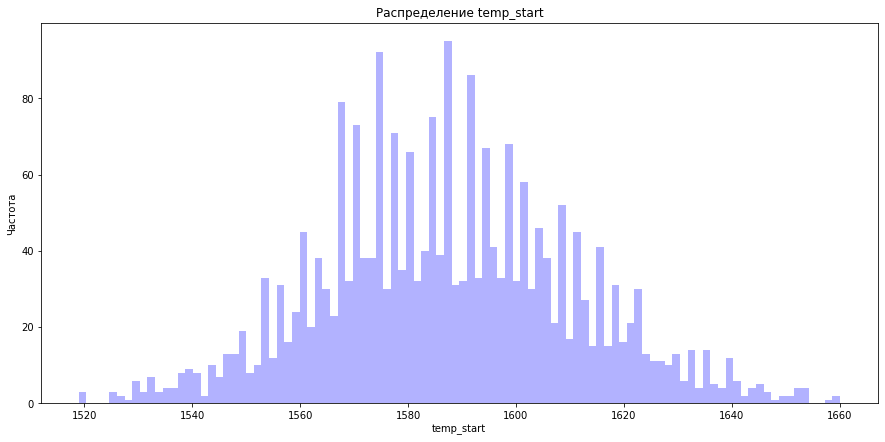

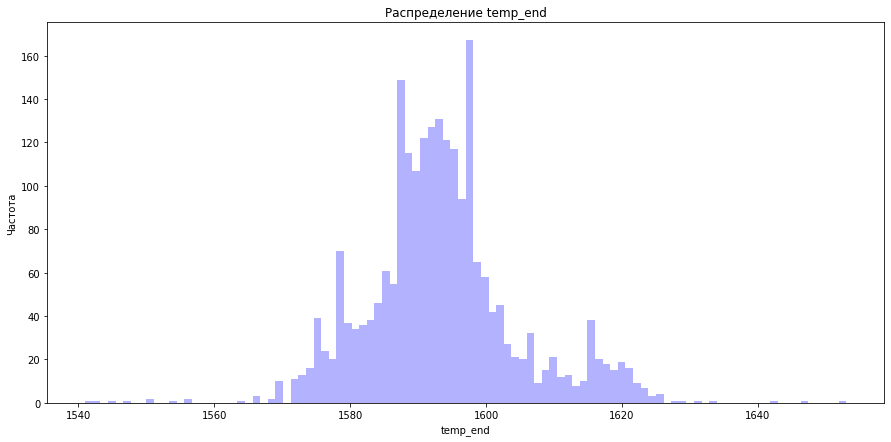

In [84]:
# строим графики для температур
for i in df_steel_process_drop[['temp_start', 'temp_end']]:
    plt.figure(figsize=(15,7))    
    ax = df_steel_process_drop[i].plot(kind='hist', bins=100, color='blue', alpha=0.3)
    ax.set_title(f'Распределение {i}')
    ax.set_xlabel(f'{i}')
    ax.set_ylabel('Частота')
    plt.show()

In [85]:
display(df_steel_process_drop[['temp_start', 'temp_end']].info())
display(df_steel_process_drop[['temp_start', 'temp_end']].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp_start  2329 non-null   float64
 1   temp_end    2329 non-null   float64
dtypes: float64(2)
memory usage: 54.6 KB


None

,temp_start,temp_end
count,2329.000000,2329.000000
mean,1587.386003,1593.365393
std,23.619841,11.200915
min,1519.000000,1541.000000
25%,1571.000000,1587.000000
50%,1587.000000,1593.000000
75%,1603.000000,1598.000000
max,1660.000000,1653.000000


Распределение начальной температуры нормальное, почти симметричное. Всплески чередуются через примерно равные интервалы, что,  возможно, свидетельствуют о погрешности прибора измерения температур или округлении до ближайшего четного/нечетного числа.    
Распределение конечной температуры тоже нормальное, но со смещением влево, как и в исходных данных. Наблюдаем такие же чередующиеся  всплески, что говорит о системе. Видимо, все же причина в приборе измерения. Крайние температуры справа можно отнести к выбросам.

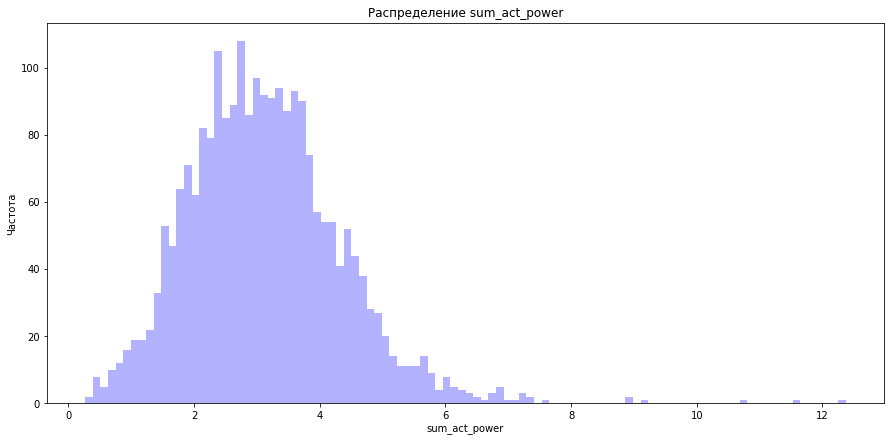

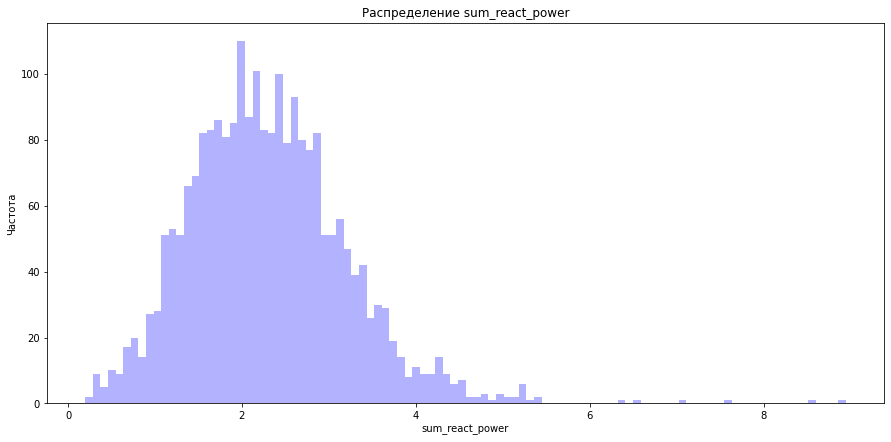

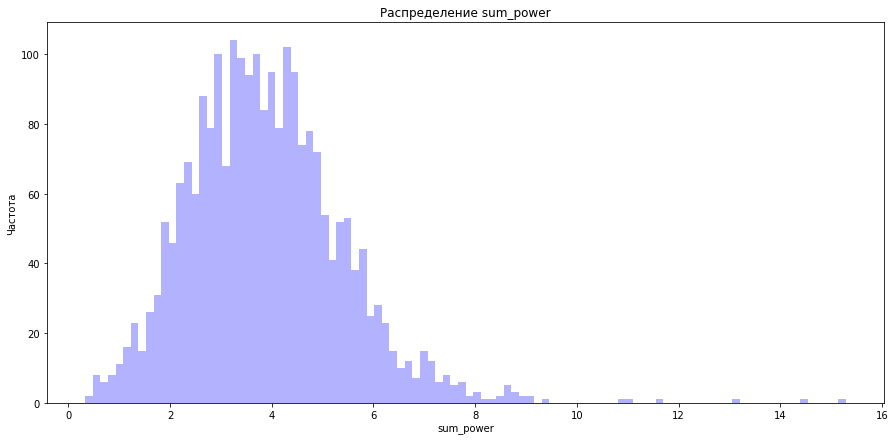

In [86]:
# строим графики для мощности
for i in df_steel_process_drop[['sum_act_power','sum_react_power','sum_power']]:
    plt.figure(figsize=(15,7))    
    ax = df_steel_process_drop[i].plot(kind='hist', bins=100, color='blue', alpha=0.3)
    ax.set_title(f'Распределение {i}')
    ax.set_xlabel(f'{i}')
    ax.set_ylabel('Частота')
    plt.show()

In [87]:
display(df_steel_process_drop[['sum_act_power','sum_react_power','sum_power']].info())
display(df_steel_process_drop[['sum_act_power','sum_react_power','sum_power']].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sum_act_power    2329 non-null   float64
 1   sum_react_power  2329 non-null   float64
 2   sum_power        2329 non-null   float64
dtypes: float64(3)
memory usage: 72.8 KB


None

,sum_act_power,sum_react_power,sum_power
count,2329.000000,2329.000000,2329.000000
mean,3.125033,2.300522,3.884654
std,1.221007,0.903968,1.518157
min,0.267676,0.196228,0.331897
25%,2.293900,1.669572,2.843058
50%,3.035365,2.225398,3.767500
75%,3.834300,2.829159,4.769421
max,12.375636,8.949049,15.288270


Графики распределения мощностей похожи друг на друга. Распределения нормальные, почти симметричные. Также наблюдаем выбросы справа по оси X.

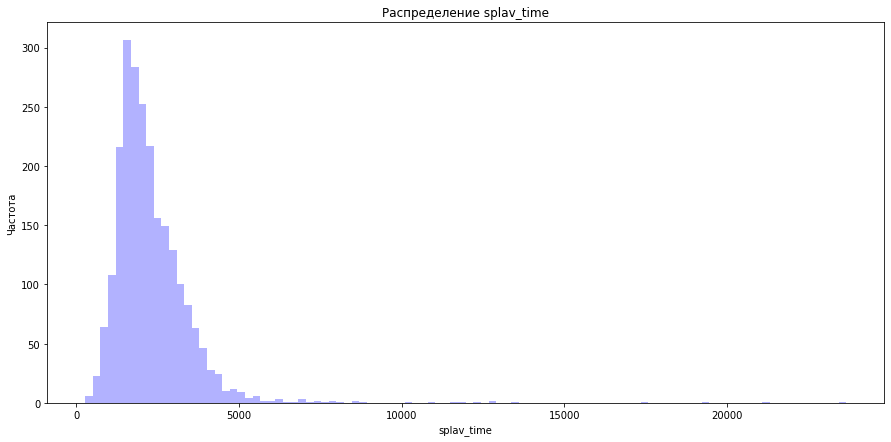

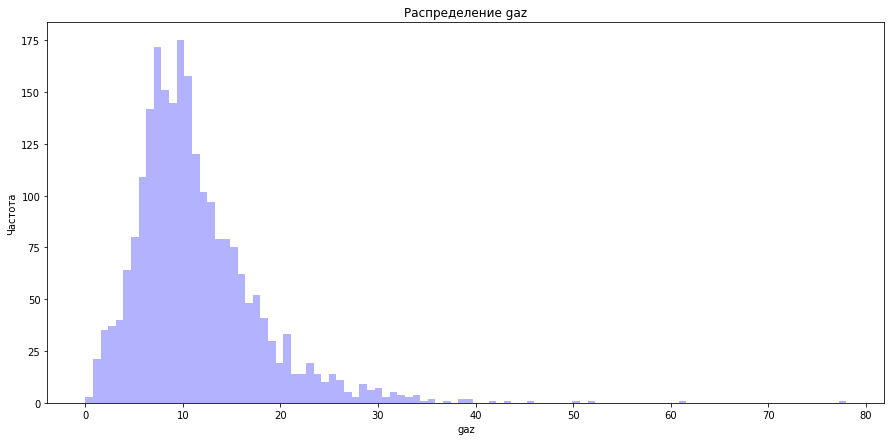

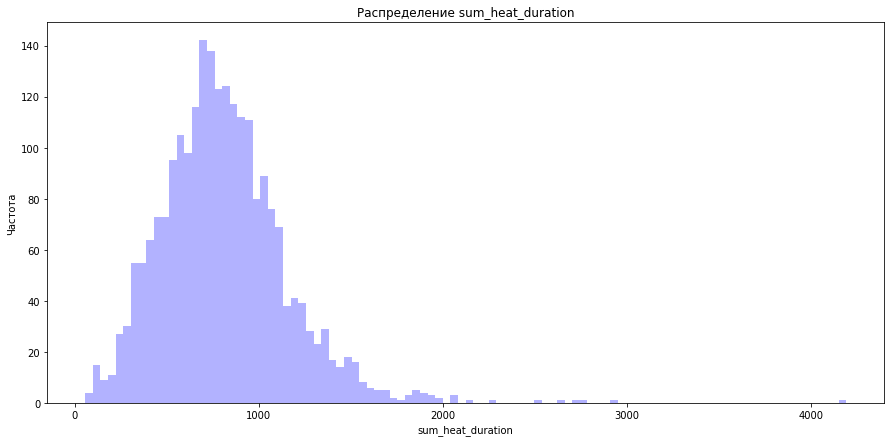

In [88]:
# строим графики для времени нагрева, объемам подачи газа и продолжжительности выплавки стали.
for i in df_steel_process_drop[['splav_time','gaz','sum_heat_duration']]:
    plt.figure(figsize=(15,7))    
    ax = df_steel_process_drop[i].plot(kind='hist', bins=100, color='blue', alpha=0.3)
    ax.set_title(f'Распределение {i}')
    ax.set_xlabel(f'{i}')
    ax.set_ylabel('Частота')
    plt.show()

In [89]:
display(df_steel_process_drop[['splav_time','sum_heat_duration','gaz']].info())
display(df_steel_process_drop[['splav_time','sum_heat_duration','gaz']].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   splav_time         2329 non-null   float64
 1   sum_heat_duration  2329 non-null   float64
 2   gaz                2329 non-null   float64
dtypes: float64(3)
memory usage: 72.8 KB


None

,splav_time,sum_heat_duration,gaz
count,2329.000000,2329.000000,2329.000000
mean,2321.810219,807.600687,11.375600
std,1385.191527,340.897332,6.392041
min,270.000000,57.000000,0.008399
25%,1579.000000,581.000000,7.282948
50%,2045.000000,778.000000,10.100950
75%,2791.000000,993.000000,14.216688
max,23674.000000,4189.000000,77.995040


Распределения нормальные, но со смещением влево. У всех показателей наблюдаются выбросы справа по оси X.

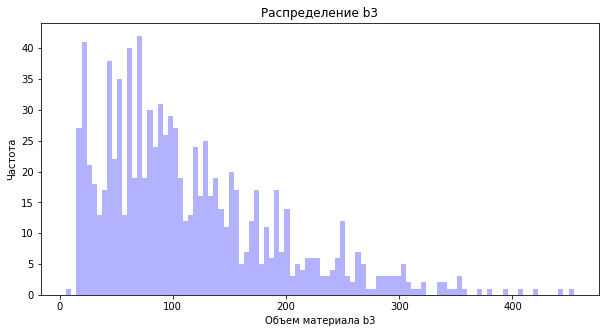

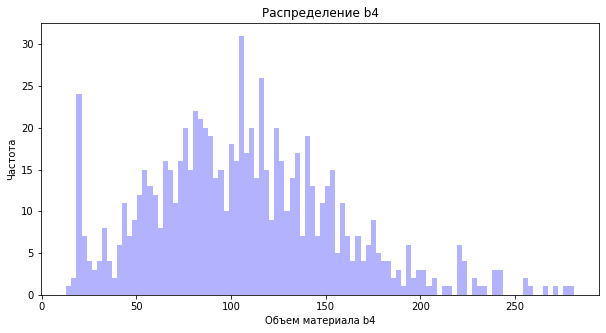

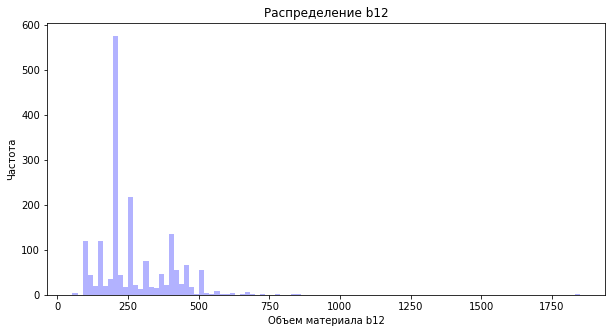

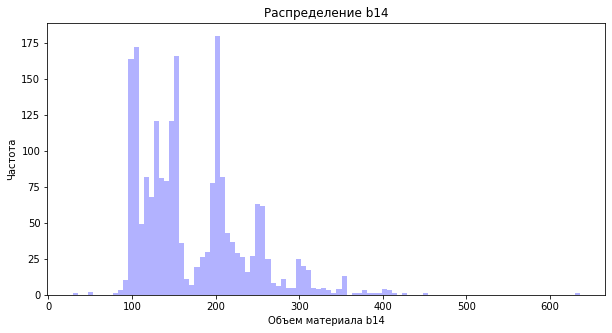

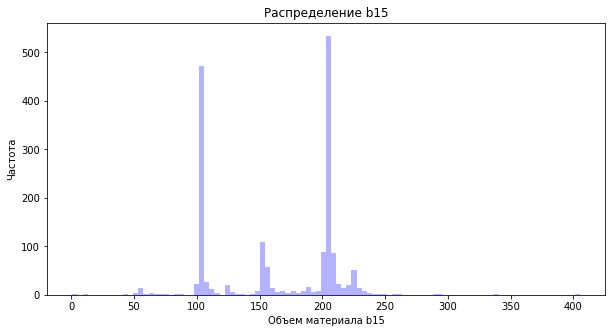

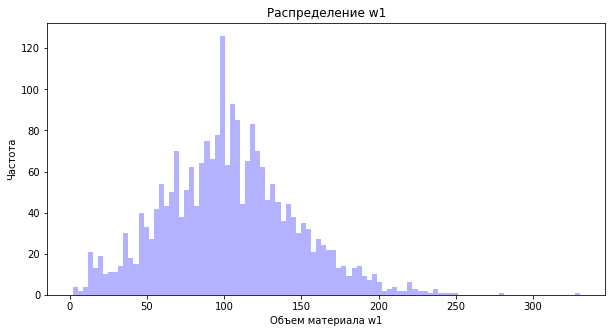

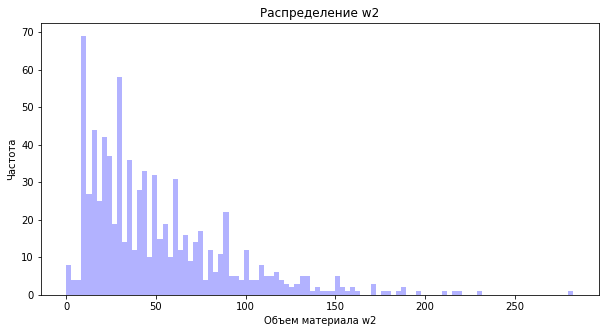

In [90]:
# строим графики для объемов сыпучих и проволочных материалов, исключив нулевые значения.
for i in df_steel_process_drop[['b3', 'b4', 'b12', 'b14', 'b15', 'w1', 'w2']]:
    plt.figure(figsize=(10,5))
    ax = (df_steel_process_drop[df_steel_process_drop[i]!=0][i]
         .plot(kind='hist', bins=100, color='blue', alpha=0.3))
    ax.set_title(f'Распределение {i}')
    ax.set_xlabel(f'Объем материала {i}')
    ax.set_ylabel('Частота')
    plt.show()

In [91]:
display(df_steel_process_drop[['b3', 'b4', 'b12', 'b14', 'b15', 'w1', 'w2']].info())
display(df_steel_process_drop[df_steel_process_drop[['b3', 'b4', 'b12', 'b14', 'b15', 'w1', 'w2']]!=0]
        [['b3', 'b4', 'b12', 'b14', 'b15', 'w1', 'w2']].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   b3      2329 non-null   float64
 1   b4      2329 non-null   float64
 2   b12     2329 non-null   float64
 3   b14     2329 non-null   float64
 4   b15     2329 non-null   float64
 5   w1      2329 non-null   float64
 6   w2      2329 non-null   float64
dtypes: float64(7)
memory usage: 145.6 KB


None

,b3,b4,b12,b14,b15,w1,w2
count,960.000000,812.000000,1812.000000,2068.000000,1699.000000,2306.000000,811.000000
mean,114.868750,106.995074,267.880795,173.271277,164.432019,103.465371,50.571346
std,77.485694,49.050943,125.588642,64.009860,50.039060,42.530971,39.755956
min,6.000000,13.000000,53.000000,29.000000,1.000000,1.918800,0.030160
25%,57.000000,73.000000,204.000000,123.000000,105.000000,75.042236,20.193680
50%,96.500000,105.000000,208.000000,153.000000,200.000000,102.053638,40.112801
75%,152.250000,136.250000,359.250000,208.000000,205.000000,128.220310,69.699761
max,454.000000,281.000000,1849.000000,636.000000,405.000000,330.314424,282.780152


Только график распределения объемов материалов b4 и w1 напоминает нормальное распределение. Остальные показатели носят скорее дискретный характер.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


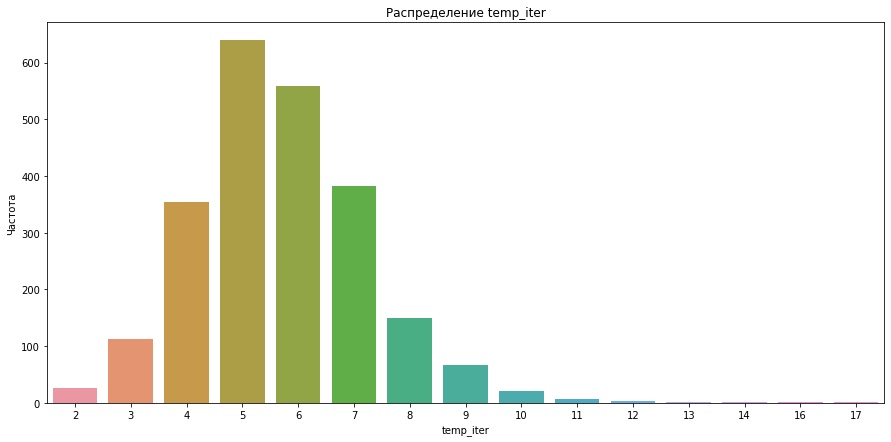

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


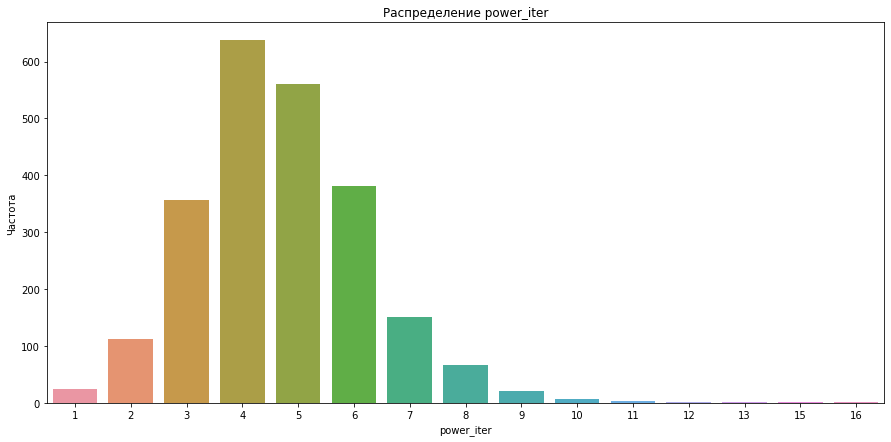

In [92]:
# строим графики для всех явно дискретных величин
for i in df_steel_process_drop.select_dtypes('int'):
    plt.figure(figsize=(15,7))    
    ax = sns.countplot(df_steel_process_drop[i])
    ax.set_title(f'Распределение {i}')
    ax.set_xlabel(f'{i}')
    ax.set_ylabel('Частота')
    plt.show()

In [93]:
display(df_steel_process_drop.select_dtypes('int').info())
display(df_steel_process_drop.select_dtypes('int').describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   temp_iter   2329 non-null   int64
 1   power_iter  2329 non-null   int64
dtypes: int64(2)
memory usage: 119.1 KB


None

,temp_iter,power_iter
count,2329.000000,2329.000000
mean,5.693860,4.695148
std,1.607639,1.606948
min,2.000000,1.000000
25%,5.000000,4.000000
50%,6.000000,5.000000
75%,7.000000,6.000000
max,17.000000,16.000000


Оба показателя имеют одинаковое количество интервалов, но со смещением на 1.

In [94]:
display(df_steel_process_drop.head())
display(df_steel_process_drop.tail())

,min_time,temp_start,max_time,temp_end,temp_iter,splav_time,sum_act_power,sum_react_power,sum_power,power_iter,...,b15,b3_time,b4_time,b12_time,b14_time,b15_time,w1,w2,w1_time,w2_time
key,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,6,1714.0,3.036730,2.142821,3.718736,5,...,154.0,2000-12-12,2019-05-03 11:28:48,2019-05-03 11:24:31,2019-05-03 11:14:50,2019-05-03 11:10:43,60.059998,0.00000,2019-05-03 11:06:19,2000-12-12 00:00:00
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,5,1265.0,2.139408,1.453357,2.588349,4,...,154.0,2000-12-12,2019-05-03 11:36:50,2019-05-03 11:53:30,2019-05-03 11:48:37,2019-05-03 11:44:39,96.052315,0.00000,2019-05-03 11:36:50,2000-12-12 00:00:00
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,6,1753.0,4.063641,2.937457,5.019224,5,...,153.0,2000-12-12,2019-05-03 12:32:39,2019-05-03 12:27:13,2019-05-03 12:21:01,2019-05-03 12:16:16,91.160157,0.00000,2019-05-03 12:11:46,2000-12-12 00:00:00
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,5,1220.0,2.706489,2.056992,3.400038,4,...,154.0,2000-12-12,2019-05-03 12:43:22,2019-05-03 12:58:00,2019-05-03 12:51:11,2019-05-03 12:46:36,89.063515,0.00000,2019-05-03 12:43:22,2000-12-12 00:00:00
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,5,1536.0,2.252950,1.687991,2.816980,4,...,152.0,2000-12-12,2019-05-03 13:30:47,2019-05-03 13:30:47,2019-05-03 13:34:12,2019-05-03 13:30:47,89.238236,9.11456,2019-05-03 13:20:44,2019-05-03 13:15:34


,min_time,temp_start,max_time,temp_end,temp_iter,splav_time,sum_act_power,sum_react_power,sum_power,power_iter,...,b15,b3_time,b4_time,b12_time,b14_time,b15_time,w1,w2,w1_time,w2_time
key,,,,,,,,,,,,,,,,,,,,,
2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0,5,1380.0,3.168133,2.210936,3.868721,4,...,223.0,2019-08-10 11:31:40,2000-12-12 00:00:00,2019-08-10 11:48:22,2019-08-10 11:42:07,2019-08-10 11:37:27,89.150879,0.00000,2019-08-10 11:31:40,2000-12-12 00:00:00
2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0,7,1705.0,4.174918,2.872031,5.070316,6,...,226.0,2000-12-12 00:00:00,2019-08-10 12:23:21,2019-08-10 12:12:32,2019-08-10 12:08:45,2019-08-10 12:03:50,114.179527,0.00000,2019-08-10 11:59:10,2000-12-12 00:00:00
2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0,4,962.0,3.605239,2.452092,4.360917,3,...,226.0,2000-12-12 00:00:00,2019-08-10 12:40:30,2019-08-10 12:40:30,2019-08-10 12:51:38,2019-08-10 12:51:38,94.086723,9.04800,2019-08-10 12:46:10,2019-08-10 12:40:30
2498,2019-08-10 12:58:11,1591.0,2019-08-10 13:23:31,1594.0,6,1520.0,3.202310,2.239820,3.909917,5,...,207.0,2019-08-10 13:21:18,2000-12-12 00:00:00,2019-08-10 13:16:31,2019-08-10 13:10:59,2019-08-10 13:07:38,118.110717,0.00000,2019-08-10 13:02:54,2000-12-12 00:00:00
2499,2019-08-10 13:33:21,1569.0,2019-08-10 13:58:58,1603.0,5,1537.0,1.737084,1.296836,2.169252,4,...,227.0,2019-08-10 13:56:36,2000-12-12 00:00:00,2019-08-10 13:56:36,2019-08-10 13:56:36,2019-08-10 13:51:44,110.160958,50.00528,2019-08-10 13:45:26,2019-08-10 13:38:56


Удалим из нашего набора данные о времени.

In [95]:
no_time = df_steel_process_drop.drop(df_steel_process_drop.select_dtypes('datetime64[ns]'), axis=1)
display(no_time.columns)

Index(['temp_start', 'temp_end', 'temp_iter', 'splav_time', 'sum_act_power',
       'sum_react_power', 'sum_power', 'power_iter', 'sum_heat_duration',
       'gaz', 'b3', 'b4', 'b12', 'b14', 'b15', 'w1', 'w2'],
      dtype='object')

### Определим корреляцию между показателями

Построим тепловую карту на основе матрицы корреляции phik, чтобы оценить влияние признаков на целевой.    

In [96]:
# задаем столбцы с непрерывными признаками
interval_cols = no_time.columns

# строим матрицу
corr_matrix = no_time.phik_matrix(interval_cols = interval_cols)

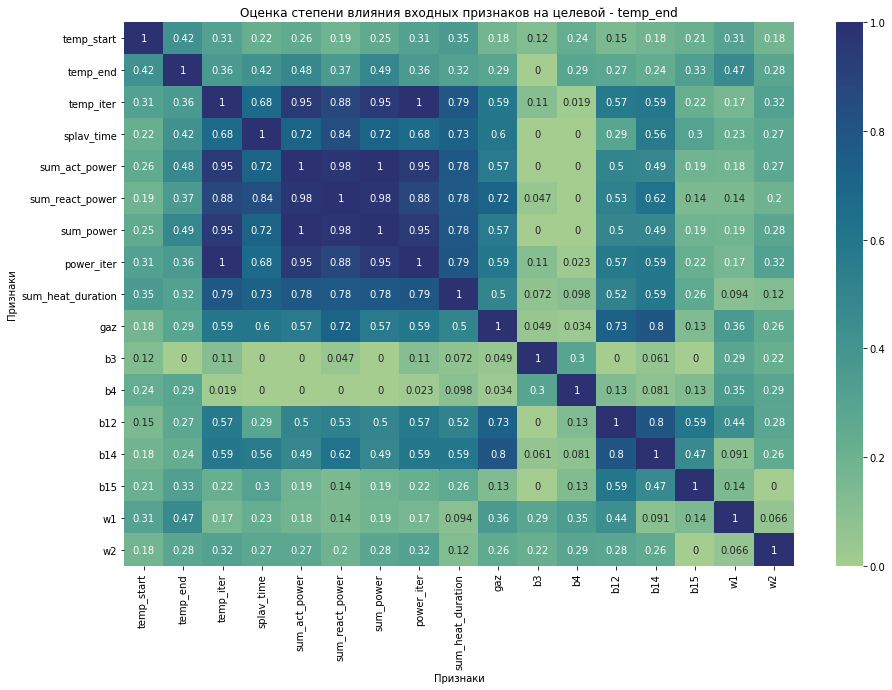

In [97]:
# построим тепловую карту для оценки степени влияния входных признаков на целевой - temp_end
plt.figure(figsize=(15,10))
#ax = sns.heatmap(df_steel_process_drop.corr(), annot=True, cmap='crest')
ax = sns.heatmap(corr_matrix, annot=True, cmap='crest')
ax.set_title('Оценка степени влияния входных признаков на целевой - temp_end')
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки')
plt.show()

По тепловой карте видим, что у нас сильная корреляция между признаками:     
- sum_act_power,
- sum_react_power,
- power_iter,
- temp_iter,
- sum_power.    
Поскольку по требованию заказчика мы рассчитывали данные по полной мощности, то оставим из 4-х колонок 'sum_power', а остальные удалим из набора.    
Коэффициент корреляции для остальных признаков набора не превышает 0.9.

In [98]:
no_time = no_time.drop(['sum_act_power','sum_react_power','power_iter', 'temp_iter'], axis=1)

In [99]:
# задаем заново столбцы с непрерывными признаками
interval_cols = no_time.columns

# перестроим матрицу
corr_matrix = no_time.phik_matrix(interval_cols = interval_cols)

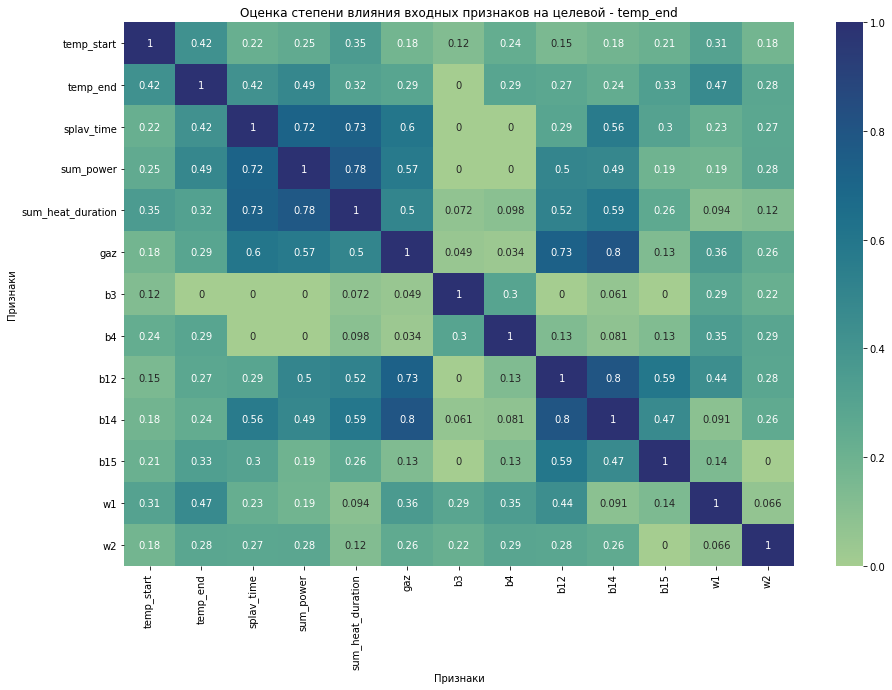

In [100]:
# построим тепловую карту для оценки степени влияния входных признаков на целевой - temp_end
plt.figure(figsize=(15,10))
ax = sns.heatmap(corr_matrix, annot=True, cmap='crest')
ax.set_title('Оценка степени влияния входных признаков на целевой - temp_end')
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки')
plt.show()

Теперь нашу модель ничего не будет отвлекать.   
Из тепловой карты видим, что есть хорошая корреляция между конечной температурой (нашим целевым признаком) и суммарной полезной мощностью, начальной температурой, временем выплавки и объемом материала w1, также осталась сильная зависимость между материалами b12, b14 и объемом газа, между временем выплавки стали и полезной мощностью, временем нагрева и объемом подаваемого газа.    
Выведем коэффициенты корреляции для всех показателей набора с нашим целевым признаком **temp_end**

In [101]:
display(abs(corr_matrix['temp_end']).sort_values())

b3                   0.000000
b14                  0.241504
b12                  0.274426
w2                   0.281627
gaz                  0.290854
b4                   0.291085
sum_heat_duration    0.317842
b15                  0.329065
splav_time           0.420093
temp_start           0.424898
w1                   0.470512
sum_power            0.487077
temp_end             1.000000
Name: temp_end, dtype: float64

То есть самая сильная связь у **temp_end** (конечной температуры) - в порядке убывания абсолютного значения - с:    
- **sum_power** (суммарная полезная мощность),
- **w1** (объемом проволочного материала №1),
- **temp_start** (начальной температурой),
- **splav_time** (время выплавки),
- **b15** (сыпучий материал №15),
- **sum_heat_duration** (суммарная продолжительность нагрева),
- **b4** (сыпучий материал №4),
- **gaz** (объем инертного газа),
- **w2** (объемом проволочного материала №2),
- **b12** (сыпучий материал №12),
- **b14** (сыпучий материал №14).

Посмотрим, сохранится ли такое влияние при анализе важности признаков в лучшей модели.

In [102]:
ml_df = no_time
display(ml_df.shape)
display(ml_df.describe())

(2329, 13)

,temp_start,temp_end,splav_time,sum_power,sum_heat_duration,gaz,b3,b4,b12,b14,b15,w1,w2
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1587.386003,1593.365393,2321.810219,3.884654,807.600687,11.375600,47.348218,37.303564,208.415629,153.853585,119.952769,102.443601,17.609859
std,23.619841,11.200915,1385.191527,1.518157,340.897332,6.392041,75.310430,58.643238,157.062272,81.404354,84.640443,43.539993,33.624771
min,1519.000000,1541.000000,270.000000,0.331897,57.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1571.000000,1587.000000,1579.000000,2.843058,581.000000,7.282948,0.000000,0.000000,105.000000,105.000000,0.000000,73.207679,0.000000
50%,1587.000000,1593.000000,2045.000000,3.767500,778.000000,10.100950,0.000000,0.000000,206.000000,149.000000,107.000000,101.119201,0.000000
75%,1603.000000,1598.000000,2791.000000,4.769421,993.000000,14.216688,80.000000,77.000000,282.000000,204.000000,204.000000,128.091599,23.102560
max,1660.000000,1653.000000,23674.000000,15.288270,4189.000000,77.995040,454.000000,281.000000,1849.000000,636.000000,405.000000,330.314424,282.780152


**Выводы по результатам исследования объединенного набора данных**:
- объединили данные из всех наборов, построили графики, чтобы посмотреть на распределение характеристик, определили, что часть характеристик имеют выбросы;
- удалили характеристики, которые не повлияют на обучение модели (все данные с датами);
- построили матрицу корреляции, в которой обнаружили сильные связи (0,9-1) между показателями и избавились от лишних, что позволило устранить сильную взаимосвязь неважных характеристик;
- почти все показатели, которые мы оставили в наборе, имеют хороршую связь с целевым признаком, вот они в порядке убывания влияния:
   - sum_power (суммарная полезная мощность),
   - w1 (объемом проволочного материала №1),
   - temp_start (начальной температурой),
   - splav_time (время выплавки),
   - b15 (сыпучий материал №15),
   - sum_heat_duration (суммарная продолжительность нагрева),
   - b4 (сыпучий материал №4),
   - gaz (объем инертного газа),
   - w2 (объемом проволочного материала №2),
   - b12 (сыпучий материал №12),
   - b14 (сыпучий материал №14).    
    
В итоговом датафрейме 2329 записей.

## Подготовка данных для машинного обучения

### Подготовка данных

In [103]:
# зададим константы для моделей
RANDOM_STATE=130125
TEST_SIZE=0.25
CV_COUNTS=5

In [104]:
drop_columns=['temp_end']

In [105]:
# выделяем целевой признак из набора
X = ml_df.drop(drop_columns, axis=1)
y = ml_df['temp_end']

In [106]:
# делим данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE,
        test_size=TEST_SIZE
    )

In [107]:
display(X_train.shape)
display(X_test.shape)

(1746, 12)

(583, 12)

### Создание пайплайна

In [108]:
# создаём списки с названиями признаков, используем 1 кодировщик
num_columns = ['sum_power','splav_time','sum_heat_duration','gaz',
               'b3','b4','b12','b14','b15','w1','w2'] # для количественных признаков

In [109]:
# создаём общий пайплайн для подготовки данных
data_preprocessor_rate = ColumnTransformer(transformers=
    [
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [110]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_rate = Pipeline([
    ('preprocessor', data_preprocessor_rate),
    ('models', LinearRegression())
])

In [111]:
# задаем гиперпараметры для моделей
param_grid_rate = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 9),
        'models__max_features': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [Ridge(random_state=RANDOM_STATE)],     
        'models__max_iter': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [XGBRegressor(random_state=RANDOM_STATE)],
        'models__learning_rate': [x/100 for x in range(1, 25)],   
        'models__max_depth': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }     
]

In [112]:
# запускаем поиск лучшей модели и ее параметров
randomized_search_rate = RandomizedSearchCV(
    pipe_final_rate, 
    param_grid_rate, 
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

**вывод по результатам подготовки модели**:
- мы разделили итоговый набор на тренировочную и тестовую выборки в пропорции 3:1,
- выбрали модели для обучения:
     - LinearRegression,
     - DecisionTreeRegressor,
     - Ridge,
     - XGBRegressor,
- подобрали гиперпараметры, которые будут меняться после получения оценок по результатам обучения моделей,
- собрали итоговый пайплайн, в котором использовали только 1 кодировщик численных показателей.

## Обучение моделей машинного обучения

### Поиск модели по сетке с кросс-валидацией

In [113]:
# обучаем ее на тренировочной выборке
randomized_search_rate.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['sum_power',
                                                                                'splav_time',
                                                                                'sum_heat_duration',
                                                                                'gaz',
                                                                                'b3',
                                                                                'b4',
                                                                                'b12',
       

In [114]:
# выводим на экран параметры лучшей модели на тренировочных данных
print('Лучшая модель и её параметры:\n\n', randomized_search_rate.best_estimator_)
print (f'Метрика MAE лучшей модели, полученная кросс-валидацией: {-randomized_search_rate.best_score_: .2f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['sum_power', 'splav_time',
                                                   'sum_heat_duration', 'gaz',
                                                   'b3', 'b4', 'b12', 'b14',
                                                   'b15', 'w1', 'w2'])])),
                ('models',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma...portance_type=None,
                              interaction_constraints='', learning_rate=0.21,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missin

**Выводы по результатам построения модели**:
лучшей из моделей оказалась XGBRegressor, которая показала ошибку MAE=6.19.

## Выбор лучшей модели

### Выполним расчет предсказания лучшей моделью

In [115]:
# проверяем работу модели на тестовой выборке
# рассчитываем прогноз на тестовых данных
y_test_pred = randomized_search_rate.predict(X_test)

# выводим значение метрики MAE и R2 для тестовых данных
print(f'Метрика MAE на тестовой выборке:', round(mean_absolute_error(y_test, y_test_pred),2))
print(f'Метрика R2 на тестовой выборке:', round(r2_score(y_test, y_test_pred),2))

Метрика MAE на тестовой выборке: 5.97
Метрика R2 на тестовой выборке: 0.5


Полученная оценка удовлетворяет условию заказчика, поскольку менее 6.8

Проведем дамми-тест

In [116]:
# создание и обучение модели DummyClassifier 
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# оценка качества модели по метрике mae и r2
dummy_mae = mean_absolute_error(y_test, dummy_model_preds)
print('Model MAE =', round(dummy_mae, 2)) 
dummy_r2 = r2_score(y_test, dummy_model_preds)
print('Model R2 =', round(dummy_r2, 2))

Model MAE = 8.11
Model R2 = -0.0


Метрики дамми-модели ниже метрик, полученных обученной моделью.

### Исследование важности признаков

In [117]:
df1 = pd.DataFrame(X_train.columns, columns=['feat'])
df2 = pd.DataFrame(randomized_search_rate.best_estimator_.named_steps["models"].feature_importances_, columns=['imp'])
df2 = df2.join(df1, how='inner').set_index('feat')
display(df2)

,imp
feat,
temp_start,0.030342
splav_time,0.059502
sum_power,0.089095
sum_heat_duration,0.042942
gaz,0.021084
b3,0.126532
b4,0.032389
b12,0.055994
b14,0.184595


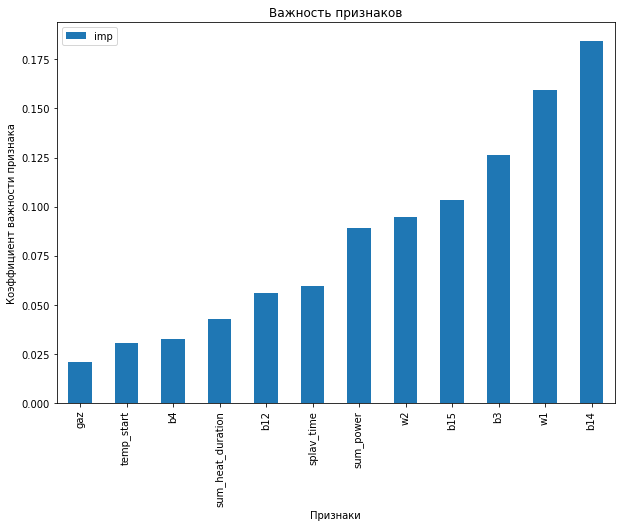

In [118]:
# отобразим на графике важность признаков
ax = df2.sort_values(by='imp').plot.bar()
ax.set_title('Важность признаков')
ax.set_xlabel('Признаки')
ax.set_ylabel('Коэффициент важности признака')
plt.show()

**Вывод по результатам оценки важности признаков**:   

Мы провели дамми-тест, чтобы проверить, что ее оценка будет хуже, чем оценка построенной нами модели. Тест подтвердил, что обученная модель ошибается меньше. Также построили график для оценки важности признаков и выявили, что на конечную температуру особенно влияют 2 признака:
- материалы, которые добавляют в сплав: b14 и w1,
Также неплохие показатели показывают: b3, b15, w2 и суммарная полезная мощность.

## Общий вывод и рекомендации заказчику

### Общий вывод

В этом проекте перед нами стояла задача построить модель машинного обучения, которая будет рассчитывать итоговую температуру выплавки стали (с целью экономии электроэнергии), для этого мы:    
- исследовали полученные от заказчика исходных данные с результатами фиксации показателей процесса выплавки стали;
- провели исследовательский анализ исходных данных:
    - data_arc_new — данные об электродах;
    - data_bulk_new — данные о подаче сыпучих материалов (объём);
    - data_bulk_time_new — данные о подаче сыпучих материалов (время);
    - data_gas_new — данные о продувке сплава газом;
    - data_temp_new — результаты измерения температуры;
    - data_wire_new — данные о проволочных материалах (объём);
    - data_wire_time_new — данные о проволочных материалах (время),
    в которых обнаружили некорректные и пропущенные значения;
- поскольку в исходных данных были наборы, которые содержали несколько записей о процессах внутри одной партии, то мы агрегировали показатели в этих наборах и рассчитали новые показатели, которые могли бы нам пригодиться;
- перед объединением наборов в один мы удалили некорректные данные (отрицательную мощность, одиночные замеры);
- объединили наборы в один по номеру партии (key);
- провели исследование итогового набора и построили матрицу корреляции для определения признаков, которые влияют на целевой признак;
- избавились от мультиколлинеарности путем удаления признаков, имеющих коэффициент корелляции>0.9;
- повторно сформировали матрицу корреляции и отобразили ее на тепловой карте;
- удалили из данных аномальные значения;
- выбрали модели:
    - LinearRegression,
    - DecisionTreeRegressor,
    - Ridge,
    - XGBRegressor;
- собрали пайплайн для поиска лучшей модели с помощью метода RandomizedSearchCV;
- определили лучшую модель по метрике MAE, ей оказалась модель XGBRegressor со следующими гиперпараметрами:
    - learning_rate=0.21,
    - max_depth=2,
    - n_estimators=100,
    - n_jobs=8,
    - StandardScaler(),
    - random_state=130125;     
  с MAE=6.19, полученной на кросс-валидации;
- протестировали лучшую модель и определили метрики MAE=5.97 и R2=0.5;
- провели дамми-тест моделью DummyClassifier, который показал метрики MAE=8.11 и R2=0;
- провели исследование важности признаков в лучшей модели: высокий коэффициент получился для материалов b14 и w1, также стоит учитывать b3, b15, w2 и показатели мощности.  

### Рекомендации заказчику



Таким образом, с помощью построенной нами модель мы предлагаем бизнесу влиять на затраты электроэнергии через определение показателей конечной температуры процесса выплавки при известных объемах сыпучих и проволочных материалов b14 и w1. Также рекомендуется обратить внимание на дополнительные 4 показателя: объемы сыпучих и проволочных материалов b3, b15, w2 и показатели мощности.

## Расчет времени, затраченного на выполнение кода

In [119]:
display(f'{round((dt.now() - start_time).seconds/60,1)} минуты')

'3.5 минуты'